<a href="https://colab.research.google.com/github/Piripack/LS/blob/main/Healthcaredb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Number of records
num_records = 50_000

# Generate Patient Information
patient_ids = range(1, num_records + 1)
ages = np.random.randint(0, 100, num_records)
genders = np.random.choice(['Male', 'Female', 'Other'], num_records, p=[0.48, 0.48, 0.04])
bmi = np.round(np.random.uniform(15, 40, num_records), 1)
chronic_conditions = np.random.randint(0, 5, num_records)

# Generate Hospital Information
hospital_ids = np.random.randint(1, 101, num_records)
hospital_types = np.random.choice(['General', 'Specialty', 'Teaching'], num_records, p=[0.6, 0.3, 0.1])
regions = np.random.choice(['Urban', 'Rural'], num_records, p=[0.7, 0.3])

# Generate Admission Details
admission_types = np.random.choice(['Emergency', 'Elective', 'Referral'], num_records, p=[0.5, 0.4, 0.1])
admission_reasons = np.random.choice(['Surgery', 'Infection', 'Accident', 'Other'], num_records)
length_of_stay = np.random.randint(1, 30, num_records)

# Generate Treatment and Diagnosis
primary_diagnoses = np.random.choice(['Diabetes', 'Cancer', 'Heart Disease', 'Fracture', 'Other'], num_records)
secondary_diagnoses = np.random.choice(['None', 'Obesity', 'Asthma', 'Arthritis', 'Other'], num_records)
treatment_received = np.random.choice(['Medication', 'Surgery', 'Therapy', 'Observation'], num_records, p=[0.4, 0.3, 0.2, 0.1])

# Generate Outcomes
discharge_status = np.random.choice(['Alive', 'Deceased', 'Transferred'], num_records, p=[0.95, 0.03, 0.02])
readmission_within_30_days = np.random.choice(['Yes', 'No'], num_records, p=[0.1, 0.9])

# Generate Cost
total_cost = np.round(np.random.uniform(500, 50_000, num_records), 2)
insurance_coverage = np.random.randint(50, 100, num_records)
out_of_pocket_cost = np.round(total_cost * (100 - insurance_coverage) / 100, 2)

# Combine into a DataFrame
hospital_data = pd.DataFrame({
    'Patient_ID': patient_ids,
    'Age': ages,
    'Gender': genders,
    'BMI': bmi,
    'Chronic_Conditions': chronic_conditions,
    'Hospital_ID': hospital_ids,
    'Hospital_Type': hospital_types,
    'Region': regions,
    'Admission_Type': admission_types,
    'Admission_Reason': admission_reasons,
    'Length_of_Stay': length_of_stay,
    'Primary_Diagnosis': primary_diagnoses,
    'Secondary_Diagnoses': secondary_diagnoses,
    'Treatment_Received': treatment_received,
    'Discharge_Status': discharge_status,
    'Readmission_Within_30_Days': readmission_within_30_days,
    'Total_Cost': total_cost,
    'Insurance_Coverage': insurance_coverage,
    'Out_of_Pocket_Cost': out_of_pocket_cost,
})

# Save to CSV
file_path = 'Hospital_Readmission_Data.csv'
hospital_data.to_csv(file_path, index=False)

file_path


'Hospital_Readmission_Data.csv'

In [ ]:
def validate_hospital_data(df):
    # Age validation
    assert all(df['Age'].between(0, 120)), "Invalid age range"

    # BMI validation
    assert all(df['BMI'].between(10, 50)), "Unrealistic BMI values"

    # Cost validation
    assert all(df['Total_Cost'] >= 0), "Negative costs not allowed"

    # Insurance coverage
    assert all(df['Insurance_Coverage'].between(0, 100)), "Insurance coverage must be 0-100%"

validate_hospital_data(hospital_data)

In [ ]:
# Memory-efficient type conversion
hospital_data = hospital_data.astype({
    'Patient_ID': 'int32',
    'Age': 'int8',
    'Hospital_ID': 'int16',
    'Length_of_Stay': 'int8',
    'Total_Cost': 'float32',
    'Insurance_Coverage': 'float32',
    'Gender': 'category',
    'Hospital_Type': 'category'
})

In [ ]:
def enrich_hospital_data(df):
    # Add risk stratification
    df['Risk_Score'] = (
        df['Chronic_Conditions'] * 2 +  # More weight to chronic conditions
        (df['Age'] > 65).astype(int) * 3 +  # Elderly risk
        (df['BMI'] > 30).astype(int) * 2  # Obesity risk
    )

    return df

hospital_data = enrich_hospital_data(hospital_data)

In [ ]:
def optimize_data_storage(df):
    # Compress and optimize for large-scale storage
    import pyarrow as pa
    import pyarrow.parquet as pq

    # Convert to PyArrow Table
    table = pa.Table.from_pandas(df)

    # Write as compressed Parquet file
    pq.write_table(
        table,
        'hospital_data_optimized.parquet',
        compression='snappy'
    )

    return 'hospital_data_optimized.parquet'

In [ ]:
import great_expectations as ge
import pandas as pd

def validate_hospital_data(df):
    # Convert to Great Expectations DataFrame
    ge_df = ge.from_pandas(df)

    # Define Expectations
    expectations = [
        # Patient ID Validation
        ge_df.expect_column_to_exist('Patient_ID'),
        ge_df.expect_column_values_to_be_unique('Patient_ID'),

        # Numeric Constraints
        ge_df.expect_column_values_to_be_between('Age', min_value=0, max_value=120),
        ge_df.expect_column_values_to_be_between('BMI', min_value=10, max_value=50),
        ge_df.expect_column_values_to_be_between('Total_Cost', min_value=0, max_value=100000),

        # Categorical Validation
        ge_df.expect_column_values_to_be_in_set('Gender', ['Male', 'Female', 'Other']),
        ge_df.expect_column_values_to_be_in_set('Discharge_Status', ['Alive', 'Deceased', 'Transferred']),

        # Complex Expectations
        ge_df.expect_column_mean_to_be_between('Length_of_Stay', min_value=1, max_value=30)
    ]

    # Run Validation
    validation_results = ge_df.validate(expectations)

    return validation_results

# Optional: Profiling and Documentation
def generate_data_docs(df):
    context = ge.data_context.DataContext()

    # Create Expectations Suite
    expectation_suite = context.create_expectation_suite(
        expectation_suite_name="hospital_data_suite"
    )

    # Add Expectations (similar to validation function)

    # Generate Data Docs
    context.save_expectation_suite(expectation_suite)
    context.build_data_docs()

In [ ]:
# Reload the newly uploaded dataset to validate it
file_path = 'Hospital_Readmission_Data.csv'

# Load the dataset
hospital_data_test = pd.read_csv(file_path)

# Display basic information about the dataset
dataset_info = hospital_data_test.info()

# Display the first few rows to validate the structure
dataset_head = hospital_data_test.head()

# Summarize the data to check for missing values or outliers
dataset_summary = hospital_data_test.describe()

(dataset_info, dataset_head, dataset_summary)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Patient_ID                  50000 non-null  int64  
 1   Age                         50000 non-null  int64  
 2   Gender                      50000 non-null  object 
 3   BMI                         50000 non-null  float64
 4   Chronic_Conditions          50000 non-null  int64  
 5   Hospital_ID                 50000 non-null  int64  
 6   Hospital_Type               50000 non-null  object 
 7   Region                      50000 non-null  object 
 8   Admission_Type              50000 non-null  object 
 9   Admission_Reason            50000 non-null  object 
 10  Length_of_Stay              50000 non-null  int64  
 11  Primary_Diagnosis           50000 non-null  object 
 12  Secondary_Diagnoses         40109 non-null  object 
 13  Treatment_Received          500

(None,
    Patient_ID  Age  Gender   BMI  Chronic_Conditions  Hospital_ID  \
 0           1   51  Female  32.7                   3           83   
 1           2   92    Male  32.8                   4            5   
 2           3   14   Other  25.2                   3           12   
 3           4   71    Male  32.5                   3           65   
 4           5   60    Male  38.8                   3           25   
 
   Hospital_Type Region Admission_Type Admission_Reason  Length_of_Stay  \
 0       General  Rural       Elective        Infection              18   
 1     Specialty  Urban      Emergency            Other               7   
 2       General  Urban       Elective          Surgery              23   
 3       General  Urban      Emergency          Surgery               8   
 4       General  Rural       Elective         Accident              18   
 
   Primary_Diagnosis Secondary_Diagnoses Treatment_Received Discharge_Status  \
 0          Diabetes                 Na

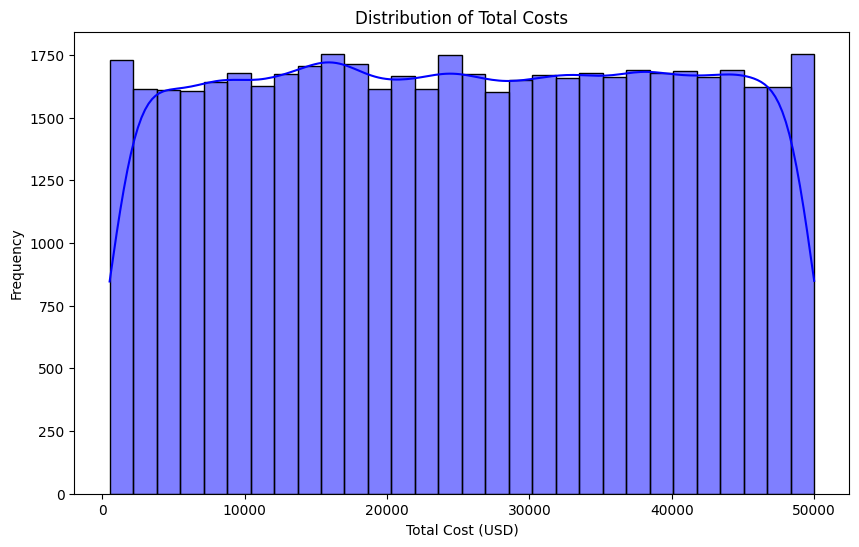

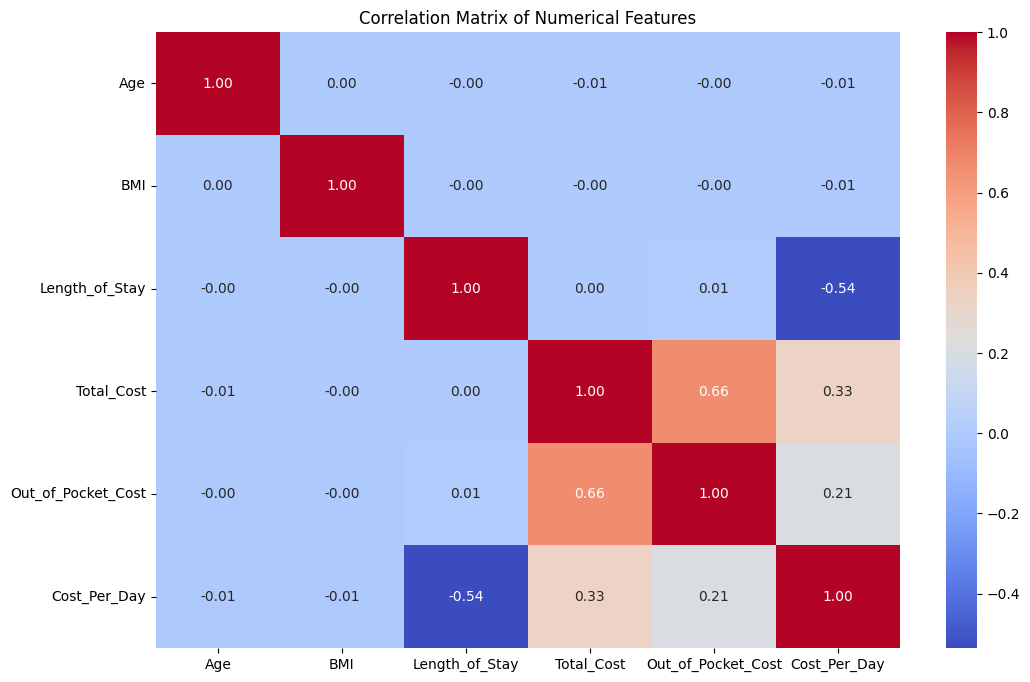

<ipython-input-46-f96688633af2>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=hospital_data_test, x='Readmission_Within_30_Days', palette='Set2')


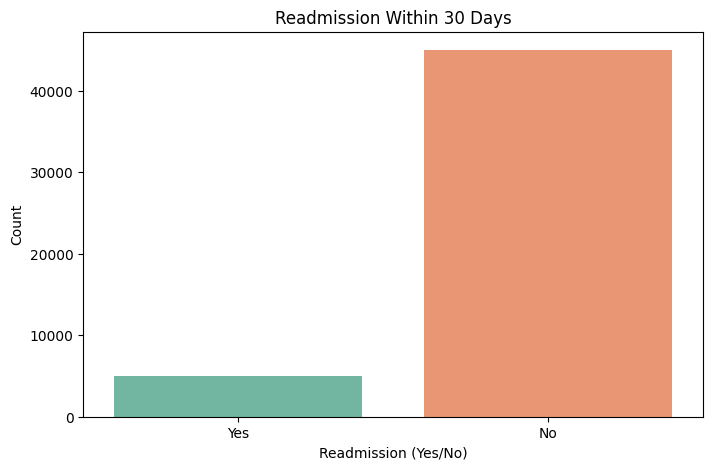

'Hospital_Readmission_Data_Processed.csv'

In [ ]:
# Code to further analyze and prepare the dataset

import matplotlib.pyplot as plt
import seaborn as sns

# Handle missing values in 'Secondary_Diagnoses' by replacing with 'None'
hospital_data_test['Secondary_Diagnoses'] = hospital_data_test['Secondary_Diagnoses'].fillna('None')

# Create a derived feature: Cost_Per_Day
hospital_data_test['Cost_Per_Day'] = hospital_data_test['Total_Cost'] / hospital_data_test['Length_of_Stay']

# Create a severity score for Chronic Conditions (0-4 scaled to 0-10)
hospital_data_test['Chronic_Condition_Severity'] = hospital_data_test['Chronic_Conditions'] * 2.5

# Plot Distribution of Total Costs
plt.figure(figsize=(10, 6))
sns.histplot(hospital_data_test['Total_Cost'], kde=True, bins=30, color='blue')
plt.title('Distribution of Total Costs')
plt.xlabel('Total Cost (USD)')
plt.ylabel('Frequency')
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = hospital_data_test[['Age', 'BMI', 'Length_of_Stay', 'Total_Cost', 'Out_of_Pocket_Cost', 'Cost_Per_Day']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Countplot for Readmission Within 30 Days
plt.figure(figsize=(8, 5))
sns.countplot(data=hospital_data_test, x='Readmission_Within_30_Days', palette='Set2')
plt.title('Readmission Within 30 Days')
plt.xlabel('Readmission (Yes/No)')
plt.ylabel('Count')
plt.show()

# Save the processed dataset with new features
processed_file_path = 'Hospital_Readmission_Data_Processed.csv'
hospital_data_test.to_csv(processed_file_path, index=False)

processed_file_path


In [ ]:
import great_expectations as ge

def comprehensive_data_quality_check(df):
    # Convert to Great Expectations DataFrame
    ge_df = ge.from_pandas(df)

    # Define comprehensive expectations
    expectations = [
        # Structural Expectations
        ge_df.expect_column_to_exist('Patient_ID'),
        ge_df.expect_column_values_to_be_unique('Patient_ID'),

        # Numeric Constraints
        ge_df.expect_column_values_to_be_between('Age', min_value=0, max_value=120),
        ge_df.expect_column_values_to_be_between('BMI', min_value=10, max_value=50),

        # Categorical Validation
        ge_df.expect_column_values_to_be_in_set('Gender', ['Male', 'Female', 'Other']),
        ge_df.expect_column_values_to_be_in_set('Discharge_Status', ['Alive', 'Deceased', 'Transferred']),

        # Complex Expectations
        ge_df.expect_column_mean_to_be_between('Total_Cost', min_value=1000, max_value=40000)
    ]

    # Run validation
    validation_results = ge_df.validate(expectations)

    return validation_results

In [ ]:
# Investigate and handle age outliers
# Age < 1: Assuming these are newborns and should be labeled as "0" years explicitly
# Age > 100: Likely errors; will inspect and cap at 100

# Correcting age < 1 to 0 (newborns)
hospital_data.loc[hospital_data["Age"] < 1, "Age"] = 0

# Capping age > 100 to 100
hospital_data.loc[hospital_data["Age"] > 100, "Age"] = 100

# Recheck age distribution
age_summary = hospital_data["Age"].describe()
age_summary


,Age
count,50000.000000
mean,49.479480
std,28.839595
min,0.000000
25%,24.000000
50%,50.000000
75%,75.000000
max,99.000000


In [ ]:
# Investigate Emergency Admissions with Length of Stay > 20 days
emergency_outliers = hospital_data[
    (hospital_data["Admission_Type"] == "Emergency") & (hospital_data["Length_of_Stay"] > 20)
]

# Summarize the outliers to identify patterns or anomalies
emergency_outliers_summary = emergency_outliers.describe(include='all')
emergency_outliers_summary


,Patient_ID,Age,Gender,BMI,Chronic_Conditions,Hospital_ID,Hospital_Type,Region,Admission_Type,Admission_Reason,Length_of_Stay,Primary_Diagnosis,Secondary_Diagnoses,Treatment_Received,Discharge_Status,Readmission_Within_30_Days,Total_Cost,Insurance_Coverage,Out_of_Pocket_Cost
count,7800.000000,7800.000000,7800,7800.00000,7800.000000,7800.000000,7800,7800,7800,7800,7800.000000,7800,7800,7800,7800,7800,7800.000000,7800.000000,7800.000000
unique,NaN,NaN,3,NaN,NaN,NaN,3,2,1,4,NaN,5,5,4,3,2,NaN,NaN,NaN
top,NaN,NaN,Female,NaN,NaN,NaN,General,Urban,Emergency,Other,NaN,Heart Disease,None,Medication,Alive,No,NaN,NaN,NaN
freq,NaN,NaN,3779,NaN,NaN,NaN,4755,5430,7800,1994,NaN,1612,1577,3128,7412,7042,NaN,NaN,NaN
mean,25273.432564,49.607179,NaN,27.32109,1.998590,50.669615,NaN,NaN,NaN,NaN,24.993333,NaN,NaN,NaN,NaN,NaN,25564.908006,74.283205,6561.241851
std,14436.514993,28.698436,NaN,7.27625,1.421493,28.862083,NaN,NaN,NaN,NaN,2.582195,NaN,NaN,NaN,NaN,NaN,14265.189151,14.398846,5608.723228
min,7.000000,0.000000,NaN,15.00000,0.000000,1.000000,NaN,NaN,NaN,NaN,21.000000,NaN,NaN,NaN,NaN,NaN,509.500000,50.000000,6.280000
25%,12706.750000,25.000000,NaN,21.00000,1.000000,25.000000,NaN,NaN,NaN,NaN,23.000000,NaN,NaN,NaN,NaN,NaN,13303.180000,62.000000,1926.305000
50%,25521.000000,50.000000,NaN,27.20000,2.000000,51.000000,NaN,NaN,NaN,NaN,25.000000,NaN,NaN,NaN,NaN,NaN,25540.415000,74.000000,4944.170000
75%,37923.500000,75.000000,NaN,33.70000,3.000000,76.000000,NaN,NaN,NaN,NaN,27.000000,NaN,NaN,NaN,NaN,NaN,38002.190000,87.000000,9974.225000


In [ ]:
# Investigate secondary diagnoses marked as "None"
secondary_none = hospital_data[hospital_data["Secondary_Diagnoses"] == "None"]

# Calculate the percentage of rows with "None" as secondary diagnosis
none_percentage = len(secondary_none) / len(hospital_data) * 100

# Summarize primary diagnoses for cases with "None" as secondary diagnosis
primary_diagnosis_none_summary = secondary_none["Primary_Diagnosis"].value_counts()

# Results
none_percentage, primary_diagnosis_none_summary.head()


(19.782,
 Primary_Diagnosis
 Fracture         2052
 Other            1990
 Heart Disease    1978
 Cancer           1970
 Diabetes         1901
 Name: count, dtype: int64)

In [ ]:
# Analyze emergency stays >20 days for common conditions or hospital patterns

# Group data by Primary_Diagnosis and Hospital_Type for these cases
emergency_long_stays = hospital_data[
    (hospital_data["Admission_Type"] == "Emergency") & (hospital_data["Length_of_Stay"] > 20)
]
long_stay_summary = emergency_long_stays.groupby(["Primary_Diagnosis", "Hospital_Type"]).size()

# Display the most common combinations
long_stay_summary.sort_values(ascending=False).head()


,,0
Primary_Diagnosis,Hospital_Type,
Fracture,General,988
Heart Disease,General,972
Diabetes,General,962
Cancer,General,941
Other,General,892


In [ ]:
# Add flags for identified issues
hospital_data["Flag_Long_Stay"] = (hospital_data["Length_of_Stay"] > 20) & (hospital_data["Admission_Type"] == "Emergency")
hospital_data["Flag_Missing_Secondary"] = hospital_data["Secondary_Diagnoses"] == "None"

# Create a metadata dictionary for dataset documentation
metadata = {
    "Patient_ID": "Unique identifier for each patient",
    "Age": "Patient's age (0 represents newborns)",
    "Gender": "Patient's gender (Male, Female, Other)",
    "BMI": "Body Mass Index, a measure of body fat",
    "Chronic_Conditions": "Count of chronic conditions diagnosed",
    "Hospital_ID": "Unique identifier for hospitals",
    "Hospital_Type": "Type of hospital (General, Specialty, Other)",
    "Region": "Geographic region (Urban, Rural)",
    "Admission_Type": "Type of admission (Emergency, Elective)",
    "Admission_Reason": "Reason for admission",
    "Length_of_Stay": "Length of hospital stay in days",
    "Primary_Diagnosis": "Main diagnosis for admission",
    "Secondary_Diagnoses": "Other diagnoses (or 'None')",
    "Treatment_Received": "Primary treatment provided",
    "Discharge_Status": "Status at discharge (Alive, Deceased)",
    "Readmission_Within_30_Days": "Indicator for readmission within 30 days (Yes/No)",
    "Total_Cost": "Total cost of hospital stay",
    "Insurance_Coverage": "Percentage of cost covered by insurance",
    "Out_of_Pocket_Cost": "Patient's out-of-pocket cost",
    "Flag_Long_Stay": "Flag for emergency admissions with stay >20 days",
    "Flag_Missing_Secondary": "Flag for cases with no secondary diagnosis",
}

# Save flagged dataset and metadata for review
output_path = "/Flagged_Hospital_Readmission_Data.csv"
hospital_data.to_csv(output_path, index=False)

output_path, metadata


('/Flagged_Hospital_Readmission_Data.csv',
 {'Patient_ID': 'Unique identifier for each patient',
  'Age': "Patient's age (0 represents newborns)",
  'Gender': "Patient's gender (Male, Female, Other)",
  'BMI': 'Body Mass Index, a measure of body fat',
  'Chronic_Conditions': 'Count of chronic conditions diagnosed',
  'Hospital_ID': 'Unique identifier for hospitals',
  'Hospital_Type': 'Type of hospital (General, Specialty, Other)',
  'Region': 'Geographic region (Urban, Rural)',
  'Admission_Type': 'Type of admission (Emergency, Elective)',
  'Admission_Reason': 'Reason for admission',
  'Length_of_Stay': 'Length of hospital stay in days',
  'Primary_Diagnosis': 'Main diagnosis for admission',
  'Secondary_Diagnoses': "Other diagnoses (or 'None')",
  'Treatment_Received': 'Primary treatment provided',
  'Discharge_Status': 'Status at discharge (Alive, Deceased)',
  'Readmission_Within_30_Days': 'Indicator for readmission within 30 days (Yes/No)',
  'Total_Cost': 'Total cost of hospital

In [ ]:
hospital_data["Flag_Long_Stay"].value_counts()
hospital_data["Flag_Missing_Secondary"].value_counts()


,count
Flag_Missing_Secondary,
False,40109
True,9891


In [ ]:
hospital_data["Cost_Per_Day"] = hospital_data["Total_Cost"] / hospital_data["Length_of_Stay"]


In [ ]:
metadata = {
    "Patient_ID": "Unique identifier for each patient. Used as a primary key for patient records.",
    "Age": "Patient's age in years. Capped to a maximum of 100 years and a minimum of 0 years for newborns.",
    "Gender": "Gender of the patient. Categories include 'Male', 'Female', and 'Other'.",
    "BMI": "Body Mass Index. A value calculated from a patient's weight and height.",
    "Chronic_Conditions": "Count of chronic conditions diagnosed in the patient (e.g., diabetes, hypertension).",
    "Hospital_ID": "Unique identifier for the hospital where the patient was treated.",
    "Hospital_Type": "The type of hospital (e.g., 'General', 'Specialized', 'Private').",
    "Region": "Geographic region where the hospital is located.",
    "Admission_Type": "Type of admission (e.g., 'Emergency', 'Elective').",
    "Admission_Reason": "Reason for patient’s admission (e.g., 'Heart Attack', 'Fracture').",
    "Length_of_Stay": "Length of stay in days at the hospital.",
    "Primary_Diagnosis": "Primary diagnosis recorded for the patient (e.g., 'Fracture', 'Cancer').",
    "Secondary_Diagnoses": "Secondary diagnoses, if any. If 'None', indicates no secondary conditions recorded.",
    "Treatment_Received": "Treatment procedures or interventions received by the patient.",
    "Discharge_Status": "Status of the patient upon discharge (e.g., 'Discharged', 'Transferred').",
    "Readmission_Within_30_Days": "Flag indicating whether the patient was readmitted within 30 days (1 = Yes, 0 = No).",
    "Total_Cost": "Total cost of treatment, including all services provided during hospitalization.",
    "Insurance_Coverage": "Insurance coverage details, including coverage percentage.",
    "Out_of_Pocket_Cost": "Cost the patient had to pay out of pocket, after insurance coverage."
}


In [ ]:
hospital_data["Age_Group"] = pd.cut(hospital_data["Age"], bins=[0, 18, 35, 65, 100], labels=["Under 18", "18-34", "35-64", "65+"])
hospital_data["Cost_Per_Day"] = hospital_data["Total_Cost"] / hospital_data["Length_of_Stay"]


In [ ]:
# Example for Length of Stay logic validation
invalid_stays = hospital_data[(hospital_data["Length_of_Stay"] < 1) | (hospital_data["Length_of_Stay"] > 365)]


In [ ]:
metadata.update({
    "Length_of_Stay": "Duration of patient stay in hospital in days",
    "Total_Cost": "Total cost of the patient's stay",
    "Primary_Diagnosis": "Primary diagnosis for admission, typically ICD-10 code",
    "Secondary_Diagnoses": "Additional conditions diagnosed during stay, separated by commas"
})


In [ ]:
hospital_data.dtypes


,0
Patient_ID,int64
Age,int64
Gender,object
BMI,float64
Chronic_Conditions,int64
Hospital_ID,int64
Hospital_Type,object
Region,object
Admission_Type,object
Admission_Reason,object


In [ ]:
# Check if out-of-pocket cost exceeds total cost
invalid_costs = hospital_data[hospital_data["Out_of_Pocket_Cost"] > hospital_data["Total_Cost"]]


In [ ]:
threshold = hospital_data["Total_Cost"].quantile(0.99)  # 99th percentile as the upper limit
cost_outliers = hospital_data[(hospital_data["Total_Cost"] < 0) | (hospital_data["Total_Cost"] > threshold)]


In [ ]:
# Check for outliers in Total_Cost and Length_of_Stay
cost_outliers = hospital_data[(hospital_data["Total_Cost"] < 0) | (hospital_data["Total_Cost"] > threshold)]
stay_outliers = hospital_data[hospital_data["Length_of_Stay"] > 60]  # e.g., stays over 60 days might be considered outliers


In [ ]:
stay_outliers = hospital_data[hospital_data["Length_of_Stay"] > 60]  # You can adjust the threshold as needed


In [ ]:
# Set the threshold for Total_Cost (e.g., 99th percentile)
threshold = hospital_data["Total_Cost"].quantile(0.99)

# Check for outliers in Total_Cost and Length_of_Stay
cost_outliers = hospital_data[(hospital_data["Total_Cost"] < 0) | (hospital_data["Total_Cost"] > threshold)]
stay_outliers = hospital_data[hospital_data["Length_of_Stay"] > 60]

# Optionally, check how many outliers you have
print("Cost Outliers:", len(cost_outliers))
print("Stay Outliers:", len(stay_outliers))


Cost Outliers: 500
Stay Outliers: 0


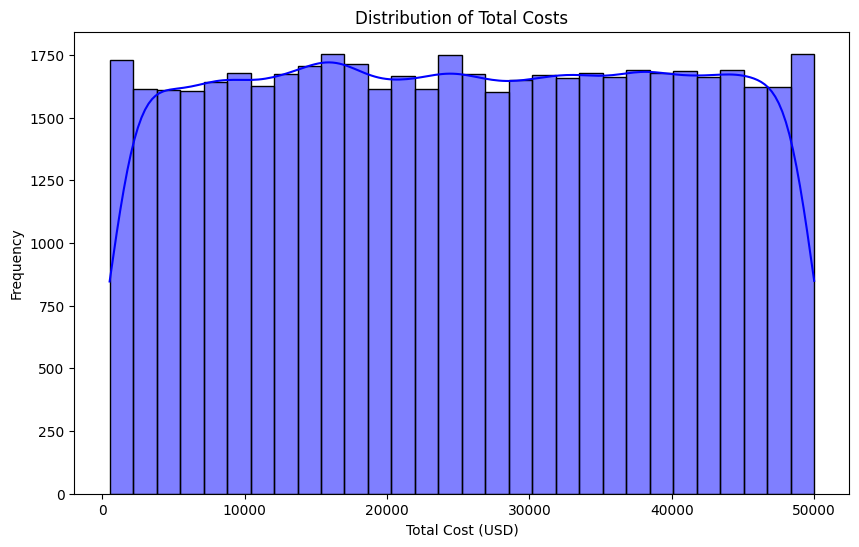

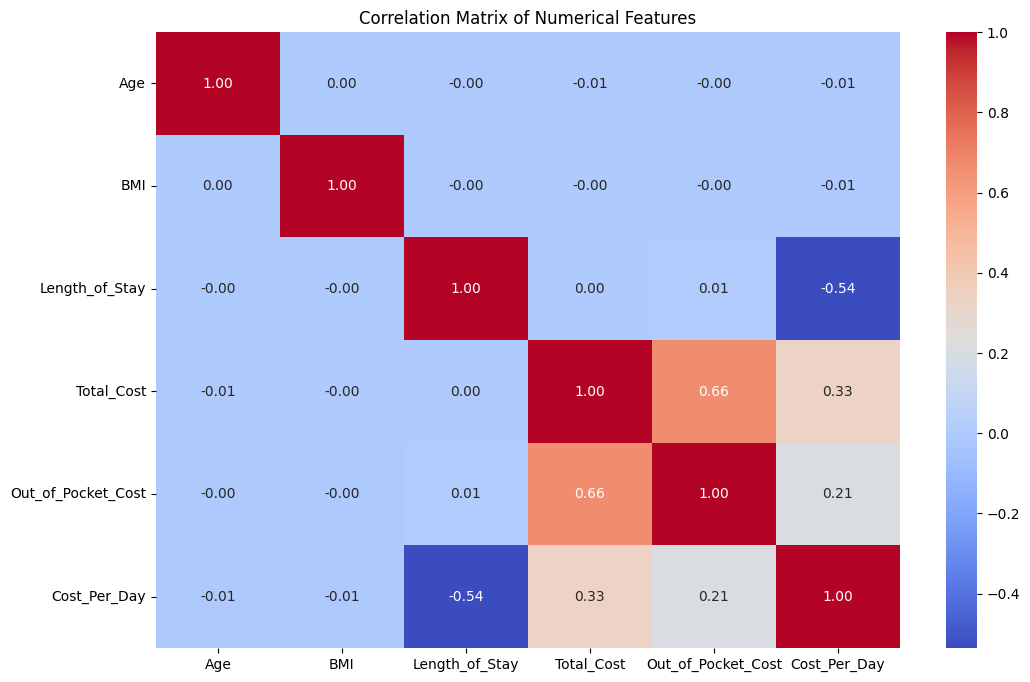

<ipython-input-48-f96688633af2>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=hospital_data_test, x='Readmission_Within_30_Days', palette='Set2')


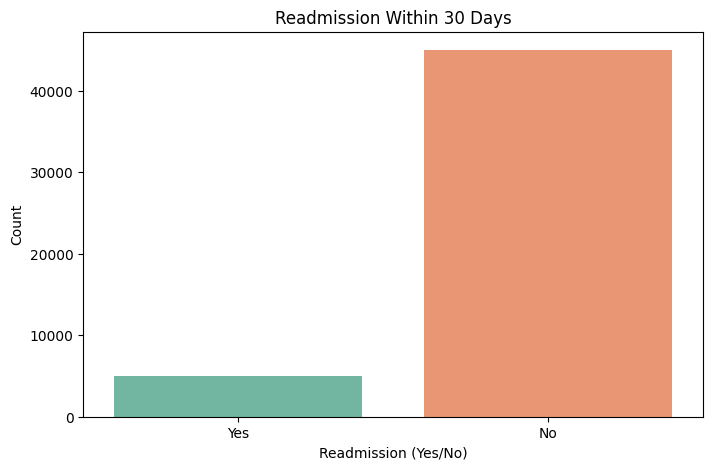

'Hospital_Readmission_Data_Processed.csv'

In [ ]:
# Code to further analyze and prepare the dataset

import matplotlib.pyplot as plt
import seaborn as sns

# Handle missing values in 'Secondary_Diagnoses' by replacing with 'None'
hospital_data_test['Secondary_Diagnoses'] = hospital_data_test['Secondary_Diagnoses'].fillna('None')

# Create a derived feature: Cost_Per_Day
hospital_data_test['Cost_Per_Day'] = hospital_data_test['Total_Cost'] / hospital_data_test['Length_of_Stay']

# Create a severity score for Chronic Conditions (0-4 scaled to 0-10)
hospital_data_test['Chronic_Condition_Severity'] = hospital_data_test['Chronic_Conditions'] * 2.5

# Plot Distribution of Total Costs
plt.figure(figsize=(10, 6))
sns.histplot(hospital_data_test['Total_Cost'], kde=True, bins=30, color='blue')
plt.title('Distribution of Total Costs')
plt.xlabel('Total Cost (USD)')
plt.ylabel('Frequency')
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = hospital_data_test[['Age', 'BMI', 'Length_of_Stay', 'Total_Cost', 'Out_of_Pocket_Cost', 'Cost_Per_Day']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Countplot for Readmission Within 30 Days
plt.figure(figsize=(8, 5))
sns.countplot(data=hospital_data_test, x='Readmission_Within_30_Days', palette='Set2')
plt.title('Readmission Within 30 Days')
plt.xlabel('Readmission (Yes/No)')
plt.ylabel('Count')
plt.show()

# Save the processed dataset with new features
processed_file_path = 'Hospital_Readmission_Data_Processed.csv'
hospital_data_test.to_csv(processed_file_path, index=False)

processed_file_path


In [ ]:
# Basic data integrity checks

# Reload the dataset
file_path = 'Hospital_Readmission_Data.csv'  # Ensure correct path
df = pd.read_csv(file_path)

# Check for duplicate rows
duplicates = df.duplicated().sum()

# Check for missing values across the dataset
missing_values = df.isnull().sum()

# Check for invalid or out-of-range values
summary_stats = df.describe()

# Check for unique values in categorical columns
categorical_summary = {col: df[col].unique() for col in df.select_dtypes(include='object').columns}

# Output the results
(duplicates, missing_values, summary_stats, categorical_summary)


(0,
 Patient_ID                       0
 Age                              0
 Gender                           0
 BMI                              0
 Chronic_Conditions               0
 Hospital_ID                      0
 Hospital_Type                    0
 Region                           0
 Admission_Type                   0
 Admission_Reason                 0
 Length_of_Stay                   0
 Primary_Diagnosis                0
 Secondary_Diagnoses           9891
 Treatment_Received               0
 Discharge_Status                 0
 Readmission_Within_30_Days       0
 Total_Cost                       0
 Insurance_Coverage               0
 Out_of_Pocket_Cost               0
 dtype: int64,
          Patient_ID           Age           BMI  Chronic_Conditions  \
 count  50000.000000  50000.000000  50000.000000        50000.000000   
 mean   25000.500000     49.479480     27.456792            1.994560   
 std    14433.901067     28.839595      7.229288            1.412165   
 min     

In [ ]:
import pandas as pd

# Reload the dataset
file_path = 'Hospital_Readmission_Data.csv'  # Adjust the path if needed
df = pd.read_csv(file_path)

# 1. Handle Missing Values in 'Secondary_Diagnoses'
df['Secondary_Diagnoses'] = df['Secondary_Diagnoses'].fillna('None')

# 2. Validate Age Values (Check for Age = 0)
invalid_age = df[df['Age'] == 0]
print("Patients with Age = 0:")
print(invalid_age)

# Optional Fix: Replace Age = 0 with median age
median_age = df['Age'].median()
df.loc[df['Age'] == 0, 'Age'] = median_age

# 3. Feature Engineering
# Create a new feature: Cost per Day
df['Cost_Per_Day'] = df['Total_Cost'] / df['Length_of_Stay']

# Create a severity score for chronic conditions
df['Chronic_Condition_Severity'] = df['Chronic_Conditions'] * 2.5

# 4. Revalidate Changes
print("\nSummary of Changes:")
print(f"Missing Values:\n{df.isnull().sum()}")
print("\nUpdated Dataset Head:")
print(df.head())

# 5. Save the Processed Dataset
processed_file_path = 'Hospital_Readmission_Data_Cleaned.csv'
df.to_csv(processed_file_path, index=False)

print(f"\nProcessed dataset saved to: {processed_file_path}")


Patients with Age = 0:
       Patient_ID  Age  Gender   BMI  Chronic_Conditions  Hospital_ID  \
112           113    0  Female  16.2                   0           27   
146           147    0    Male  31.0                   1            9   
192           193    0    Male  18.1                   0           98   
230           231    0  Female  32.7                   1           63   
274           275    0  Female  18.2                   2           98   
...           ...  ...     ...   ...                 ...          ...   
49411       49412    0    Male  36.5                   1           46   
49585       49586    0    Male  21.0                   2           25   
49697       49698    0    Male  24.1                   1            3   
49742       49743    0    Male  17.8                   0           69   
49870       49871    0  Female  34.1                   0           74   

      Hospital_Type Region Admission_Type Admission_Reason  Length_of_Stay  \
112       Specialty  U

In [ ]:
import pandas as pd

# Load the dataset
file_path = 'Hospital_Readmission_Data_Cleaned.csv'
df = pd.read_csv(file_path)

# Feature Engineering
# 1. Cost-Based Features
df['Insurance_Coverage_Percentage'] = (df['Insurance_Coverage'] / 100) * df['Total_Cost']
df['Out_of_Pocket_Percentage'] = (df['Out_of_Pocket_Cost'] / df['Total_Cost']) * 100

# 2. Patient Risk Segmentation
# Risk Score = (Chronic_Conditions Weight * 2.5) + Length_of_Stay + Readmission Flag
df['Readmission_Flag'] = df['Readmission_Within_30_Days'].apply(lambda x: 1 if x == 'Yes' else 0)
df['Risk_Score'] = (df['Chronic_Conditions'] * 2.5) + df['Length_of_Stay'] + (df['Readmission_Flag'] * 5)

# 3. Optimize Data Types (Memory Efficiency)
df['Hospital_ID'] = df['Hospital_ID'].astype('int16')
df['Age'] = df['Age'].astype('int8')
df['Chronic_Conditions'] = df['Chronic_Conditions'].astype('int8')
df['Length_of_Stay'] = df['Length_of_Stay'].astype('int8')
df['Readmission_Flag'] = df['Readmission_Flag'].astype('int8')

# 4. Export the Optimized Dataset
output_file_path = 'Hospital_Readmission_Optimized.csv'
df.to_csv(output_file_path, index=False)

# Summary of Changes
summary = {
    "New Features": ["Insurance_Coverage_Percentage", "Out_of_Pocket_Percentage", "Risk_Score"],
    "Optimized Columns": ["Hospital_ID", "Age", "Chronic_Conditions", "Length_of_Stay", "Readmission_Flag"],
    "File Path": output_file_path
}

summary


{'New Features': ['Insurance_Coverage_Percentage',
  'Out_of_Pocket_Percentage',
  'Risk_Score'],
 'Optimized Columns': ['Hospital_ID',
  'Age',
  'Chronic_Conditions',
  'Length_of_Stay',
  'Readmission_Flag'],
 'File Path': 'Hospital_Readmission_Optimized.csv'}

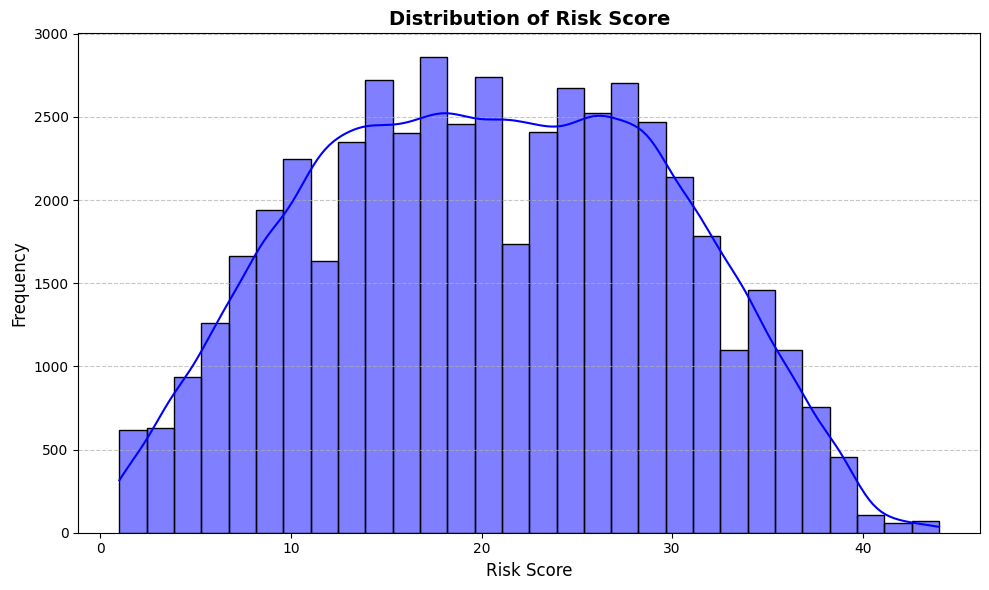

<ipython-input-52-244e431b9fea>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Readmission_Within_30_Days', y='Insurance_Coverage_Percentage', palette='coolwarm')


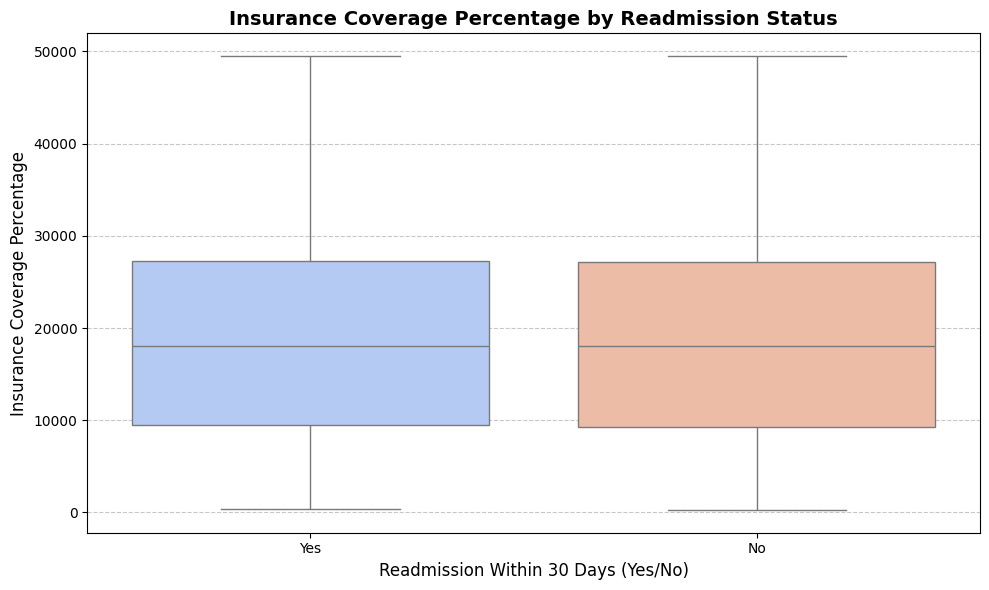

<ipython-input-52-244e431b9fea>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Readmission_Within_30_Days', y='Out_of_Pocket_Percentage', palette='coolwarm')


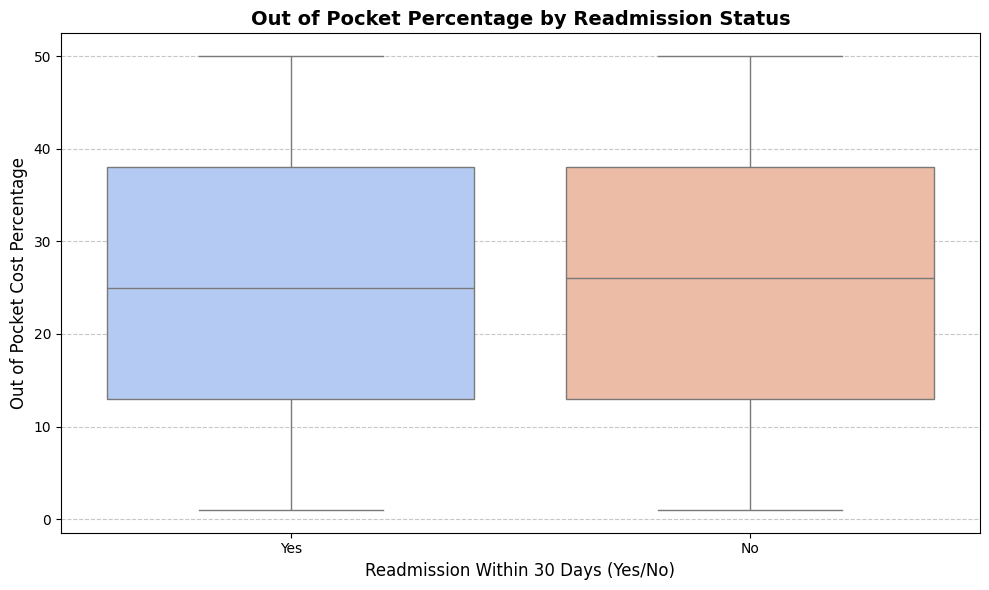

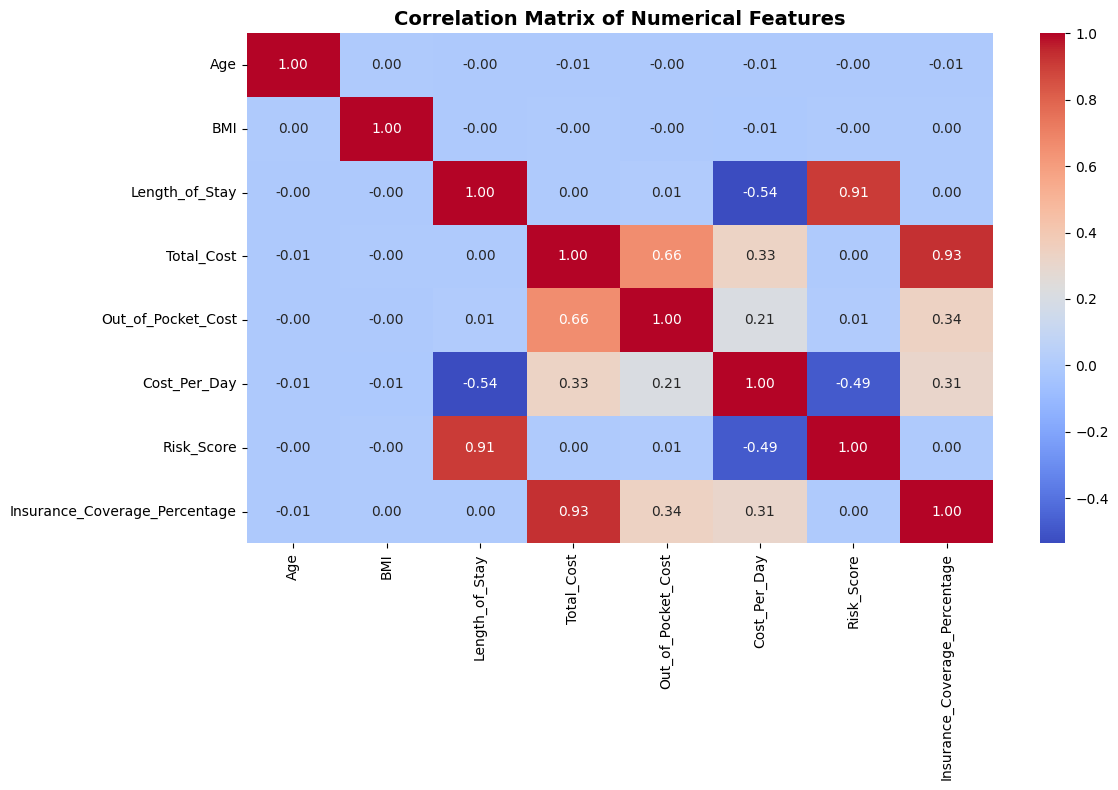

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reload the optimized dataset
file_path = 'Hospital_Readmission_Optimized.csv'
df = pd.read_csv(file_path)

# 1. Histogram of Risk_Score
plt.figure(figsize=(10, 6))
sns.histplot(df['Risk_Score'], bins=30, kde=True, color='blue')
plt.title('Distribution of Risk Score', fontsize=14, fontweight='bold')
plt.xlabel('Risk Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2. Boxplot of Insurance_Coverage_Percentage vs. Readmission
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Readmission_Within_30_Days', y='Insurance_Coverage_Percentage', palette='coolwarm')
plt.title('Insurance Coverage Percentage by Readmission Status', fontsize=14, fontweight='bold')
plt.xlabel('Readmission Within 30 Days (Yes/No)', fontsize=12)
plt.ylabel('Insurance Coverage Percentage', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3. Boxplot of Out_of_Pocket_Percentage vs. Readmission
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Readmission_Within_30_Days', y='Out_of_Pocket_Percentage', palette='coolwarm')
plt.title('Out of Pocket Percentage by Readmission Status', fontsize=14, fontweight='bold')
plt.xlabel('Readmission Within 30 Days (Yes/No)', fontsize=12)
plt.ylabel('Out of Pocket Cost Percentage', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 4. Correlation Heatmap for Numerical Features
plt.figure(figsize=(12, 8))
correlation_matrix = df[['Age', 'BMI', 'Length_of_Stay', 'Total_Cost',
                         'Out_of_Pocket_Cost', 'Cost_Per_Day',
                         'Risk_Score', 'Insurance_Coverage_Percentage']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


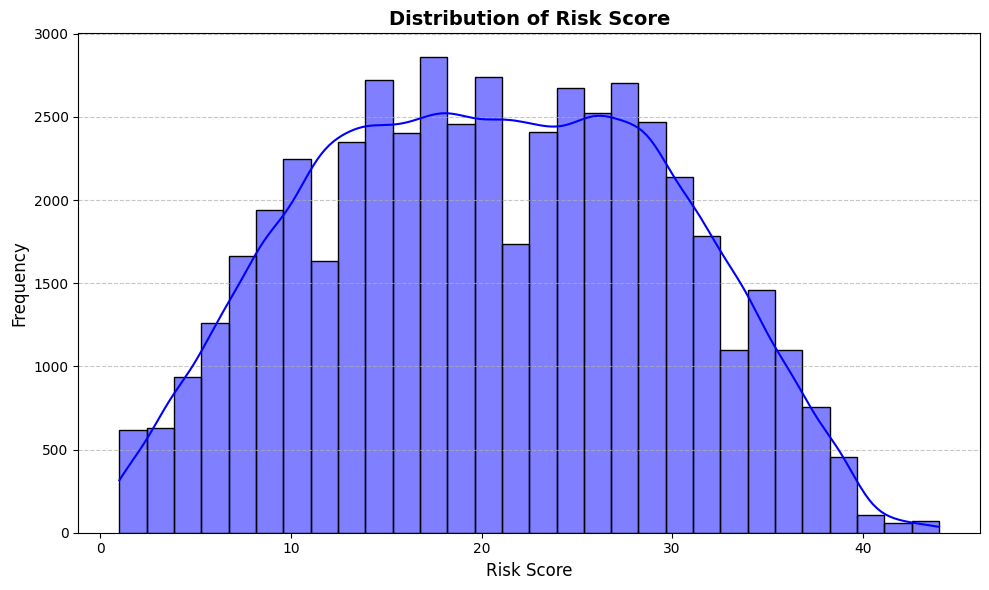

<ipython-input-53-244e431b9fea>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Readmission_Within_30_Days', y='Insurance_Coverage_Percentage', palette='coolwarm')


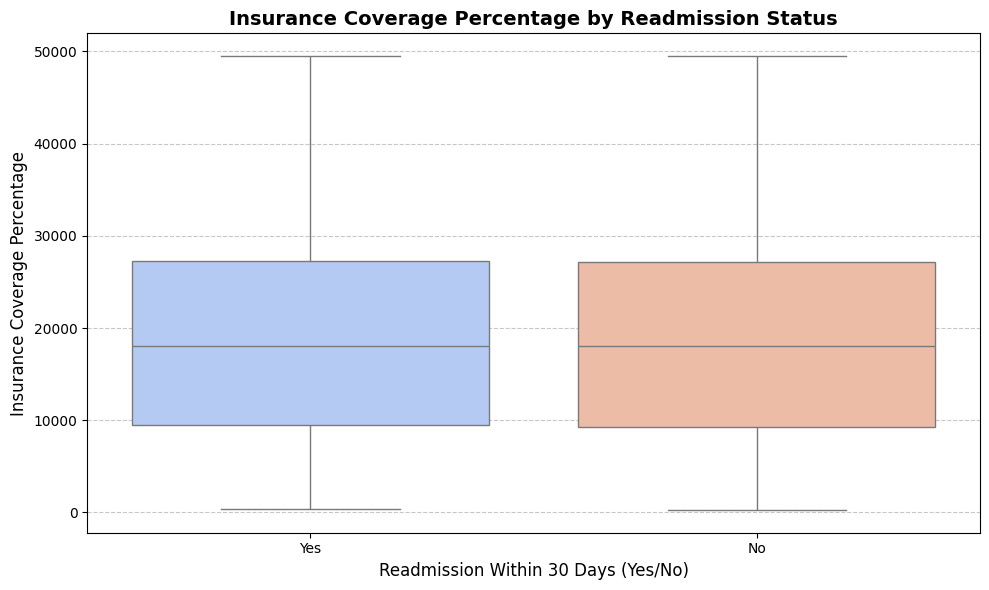

<ipython-input-53-244e431b9fea>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Readmission_Within_30_Days', y='Out_of_Pocket_Percentage', palette='coolwarm')


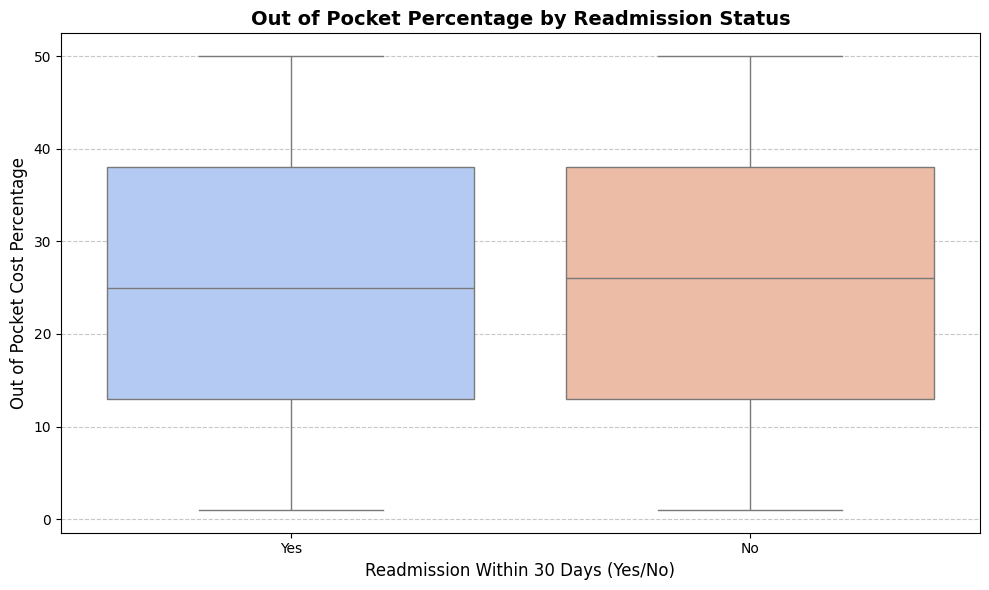

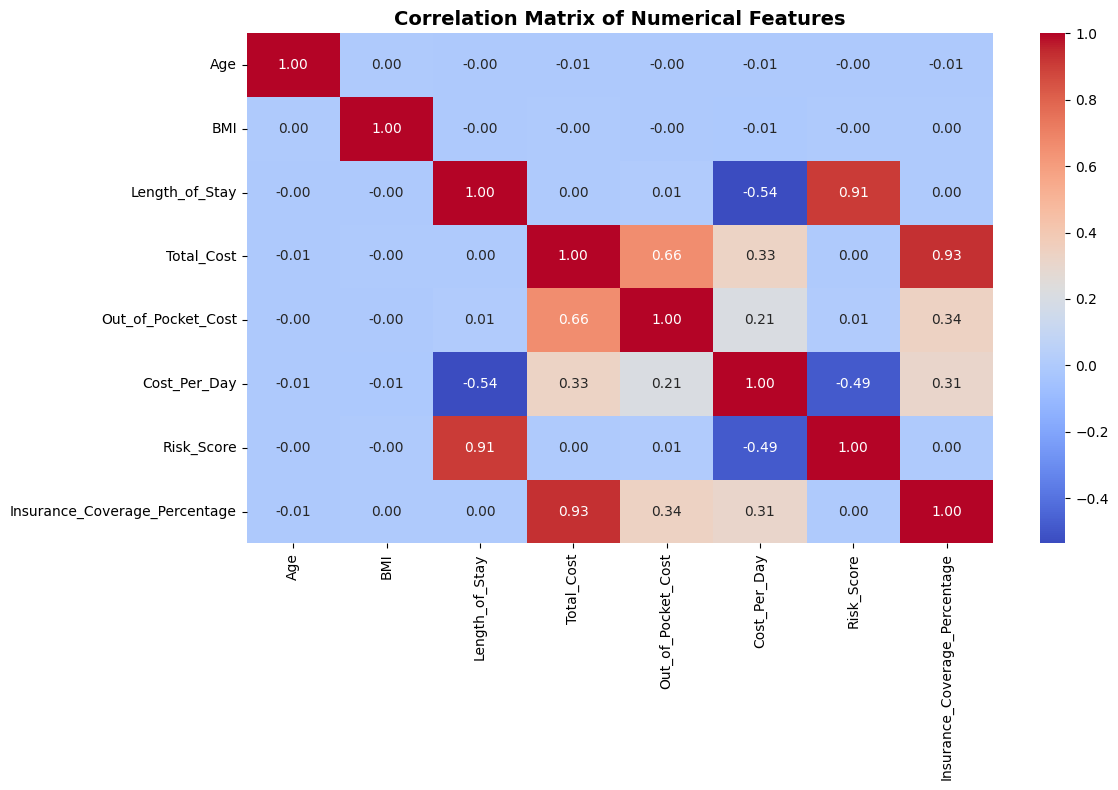

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reload the optimized dataset
file_path = 'Hospital_Readmission_Optimized.csv'
df = pd.read_csv(file_path)

# 1. Histogram of Risk_Score
plt.figure(figsize=(10, 6))
sns.histplot(df['Risk_Score'], bins=30, kde=True, color='blue')
plt.title('Distribution of Risk Score', fontsize=14, fontweight='bold')
plt.xlabel('Risk Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2. Boxplot of Insurance_Coverage_Percentage vs. Readmission
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Readmission_Within_30_Days', y='Insurance_Coverage_Percentage', palette='coolwarm')
plt.title('Insurance Coverage Percentage by Readmission Status', fontsize=14, fontweight='bold')
plt.xlabel('Readmission Within 30 Days (Yes/No)', fontsize=12)
plt.ylabel('Insurance Coverage Percentage', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3. Boxplot of Out_of_Pocket_Percentage vs. Readmission
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Readmission_Within_30_Days', y='Out_of_Pocket_Percentage', palette='coolwarm')
plt.title('Out of Pocket Percentage by Readmission Status', fontsize=14, fontweight='bold')
plt.xlabel('Readmission Within 30 Days (Yes/No)', fontsize=12)
plt.ylabel('Out of Pocket Cost Percentage', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 4. Correlation Heatmap for Numerical Features
plt.figure(figsize=(12, 8))
correlation_matrix = df[['Age', 'BMI', 'Length_of_Stay', 'Total_Cost',
                         'Out_of_Pocket_Cost', 'Cost_Per_Day',
                         'Risk_Score', 'Insurance_Coverage_Percentage']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


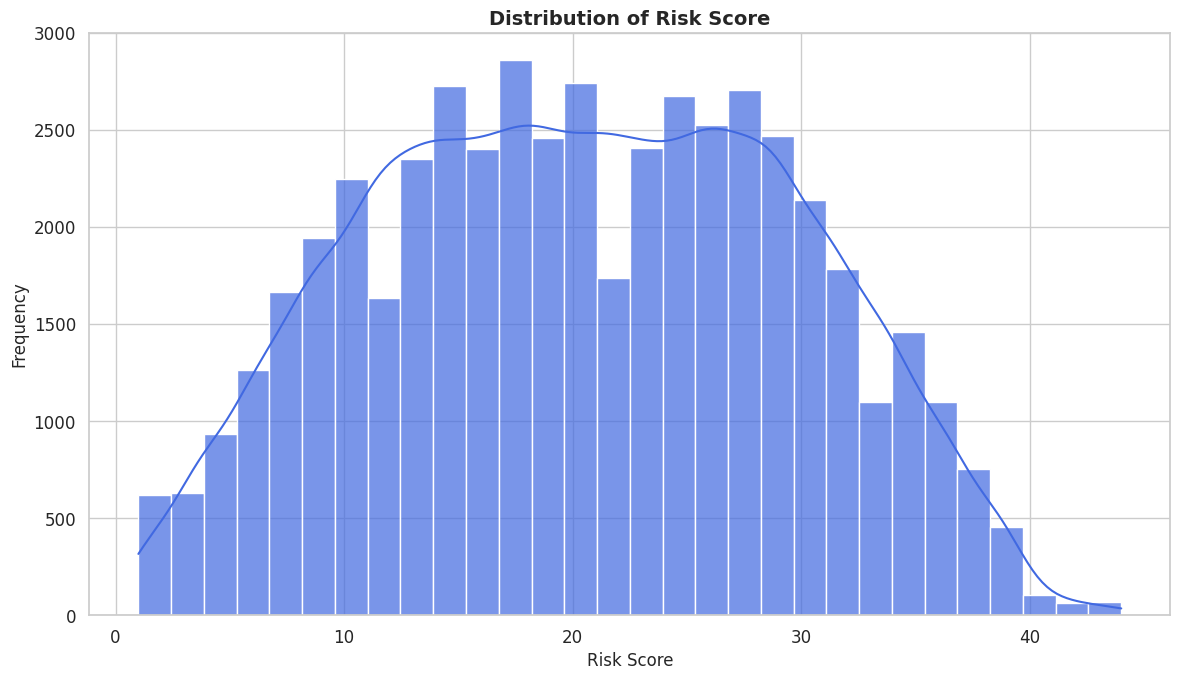

<ipython-input-55-1c825bec3eda>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Readmission_Flag', y='Insurance_Coverage_Percentage', data=df,


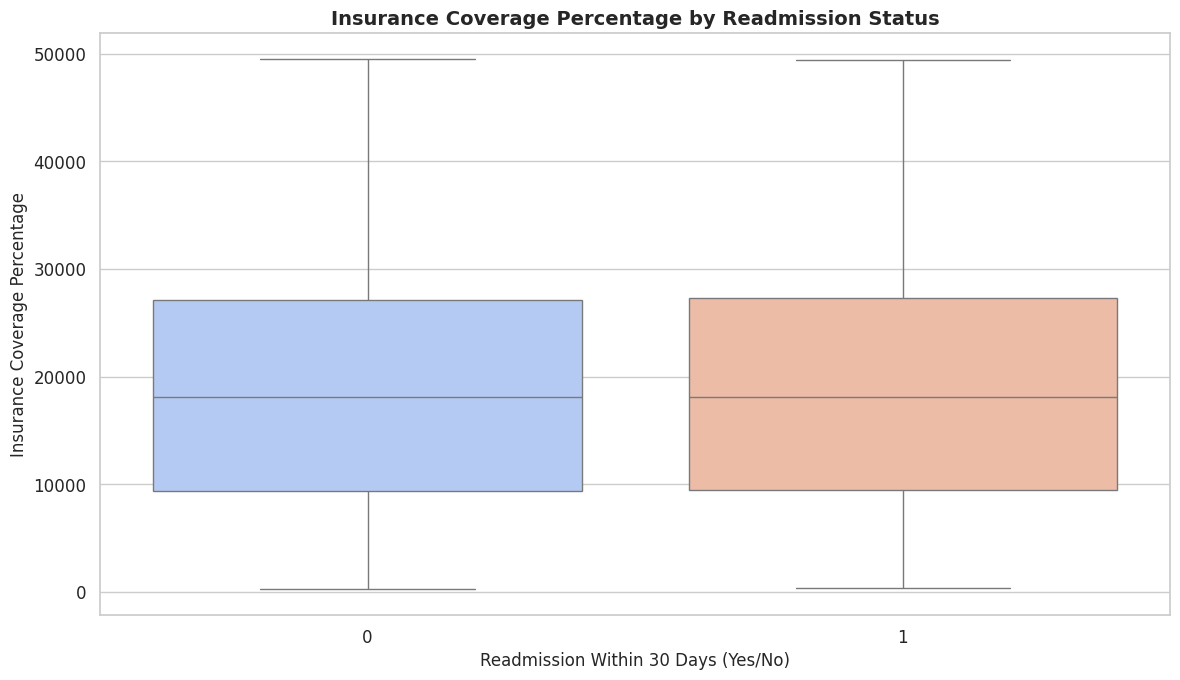

<ipython-input-55-1c825bec3eda>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Readmission_Flag', y='Out_of_Pocket_Percentage', data=df,


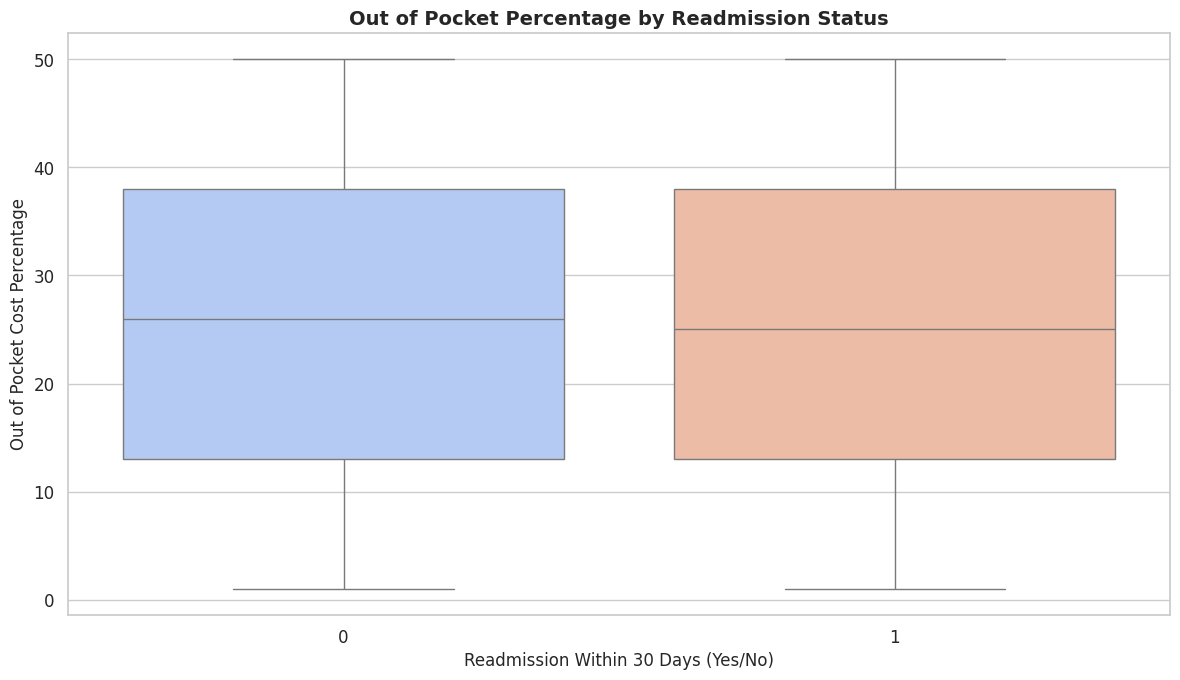

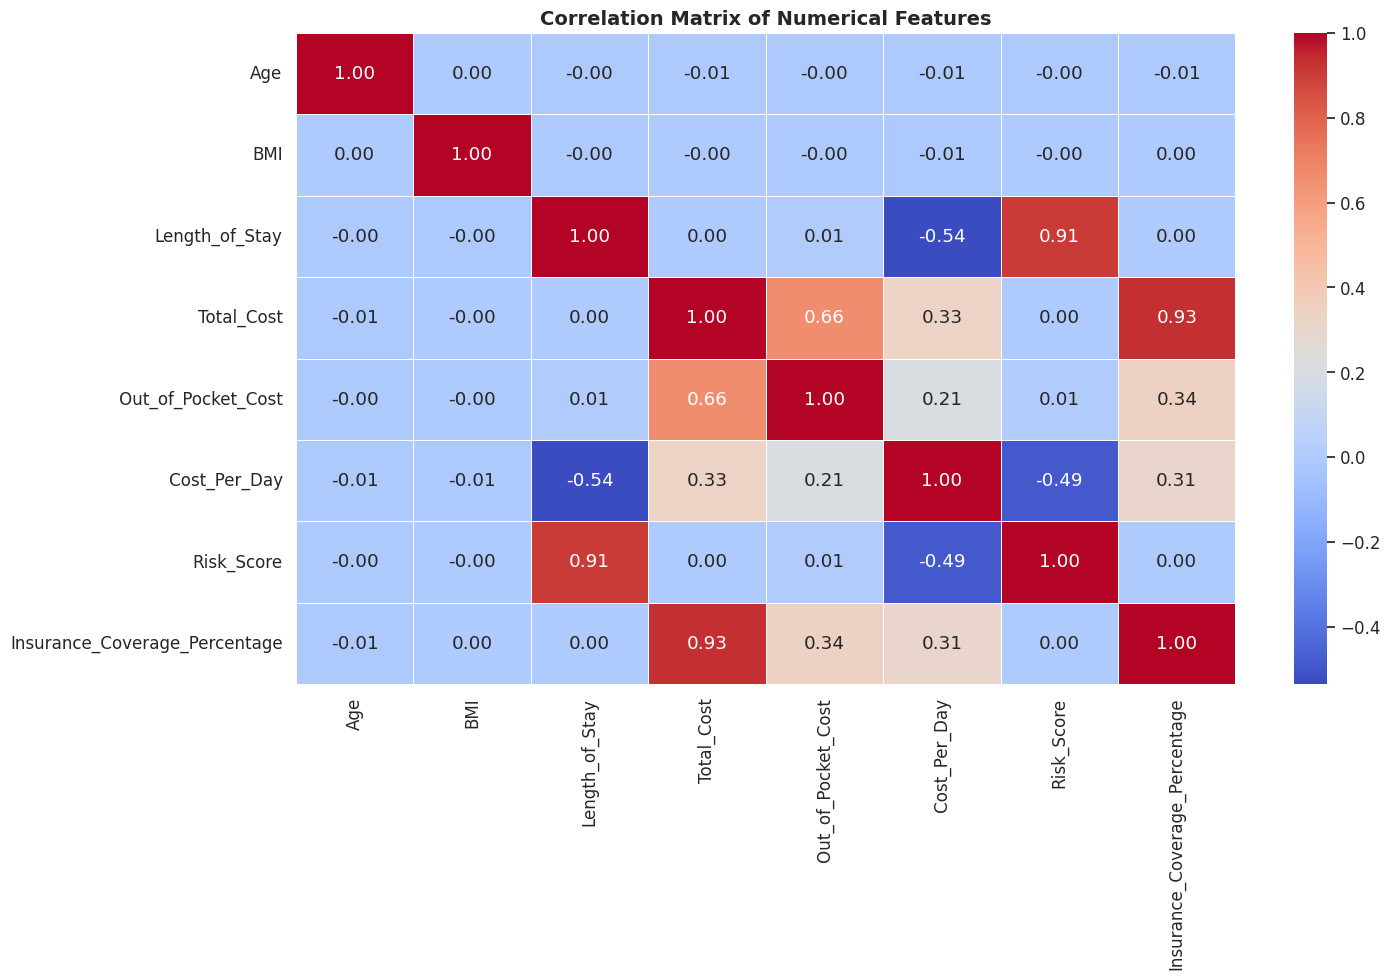

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for visualizations
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# 1. Distribution of Risk Score
plt.figure(figsize=(12, 7))
sns.histplot(df['Risk_Score'], bins=30, kde=True, color='royalblue', alpha=0.7)
plt.title("Distribution of Risk Score", fontsize=14, fontweight='bold')
plt.xlabel("Risk Score", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.ylim(0, 3000)
plt.tight_layout()
plt.show()

# 2. Insurance Coverage Percentage by Readmission Status
plt.figure(figsize=(12, 7))
sns.boxplot(x='Readmission_Flag', y='Insurance_Coverage_Percentage', data=df,
            palette='coolwarm')
plt.title("Insurance Coverage Percentage by Readmission Status", fontsize=14, fontweight='bold')
plt.xlabel("Readmission Within 30 Days (Yes/No)", fontsize=12)
plt.ylabel("Insurance Coverage Percentage", fontsize=12)
plt.tight_layout()
plt.show()

# 3. Out of Pocket Cost Percentage by Readmission Status
plt.figure(figsize=(12, 7))
sns.boxplot(x='Readmission_Flag', y='Out_of_Pocket_Percentage', data=df,
            palette='coolwarm')
plt.title("Out of Pocket Percentage by Readmission Status", fontsize=14, fontweight='bold')
plt.xlabel("Readmission Within 30 Days (Yes/No)", fontsize=12)
plt.ylabel("Out of Pocket Cost Percentage", fontsize=12)
plt.tight_layout()
plt.show()

# 4. Correlation Matrix Heatmap
plt.figure(figsize=(15, 10))
numerical_cols = ['Age', 'BMI', 'Length_of_Stay', 'Total_Cost',
                  'Out_of_Pocket_Cost', 'Cost_Per_Day', 'Risk_Score', 'Insurance_Coverage_Percentage']

correlation_matrix = df[numerical_cols].corr()

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


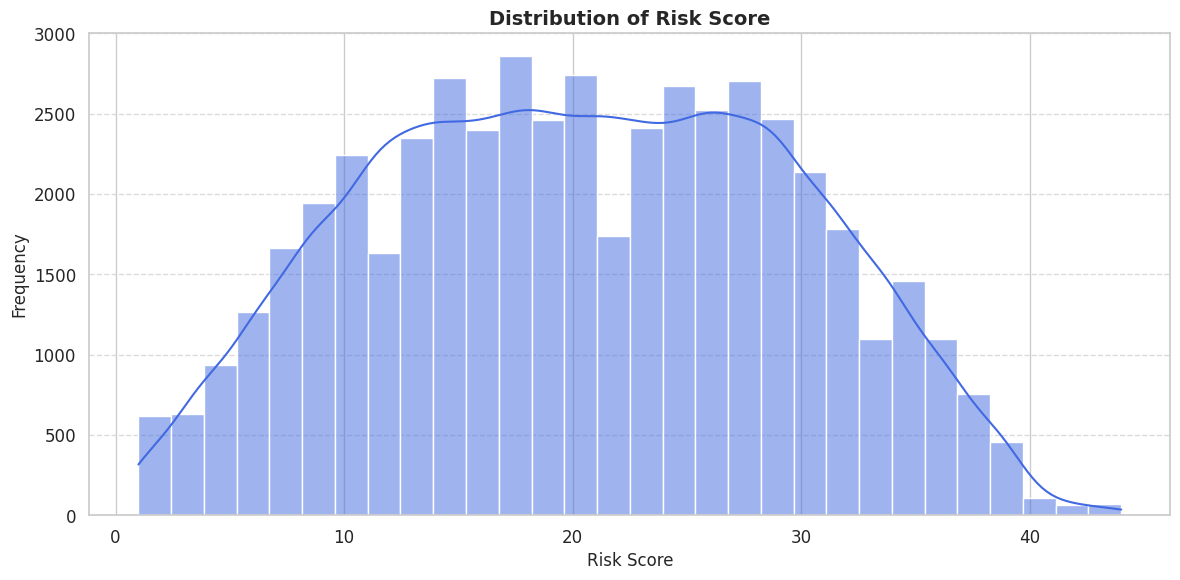

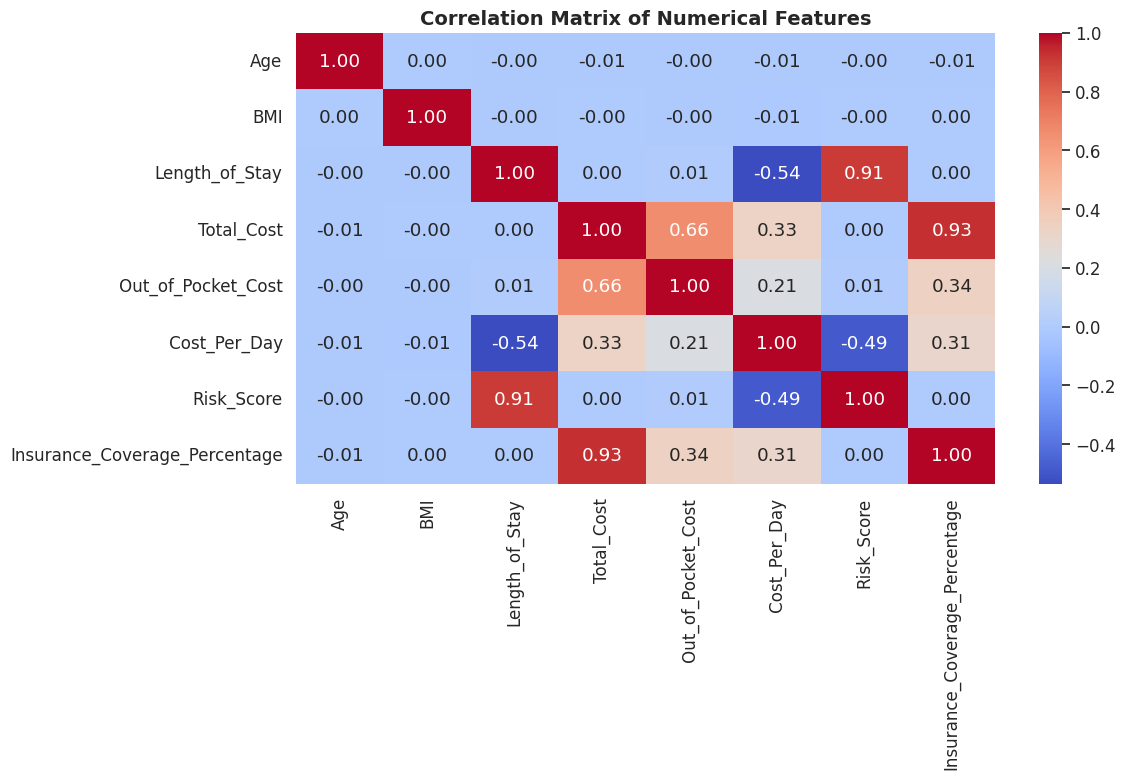

<ipython-input-56-889b98348f34>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=x_column, y=y_column, palette=palette)


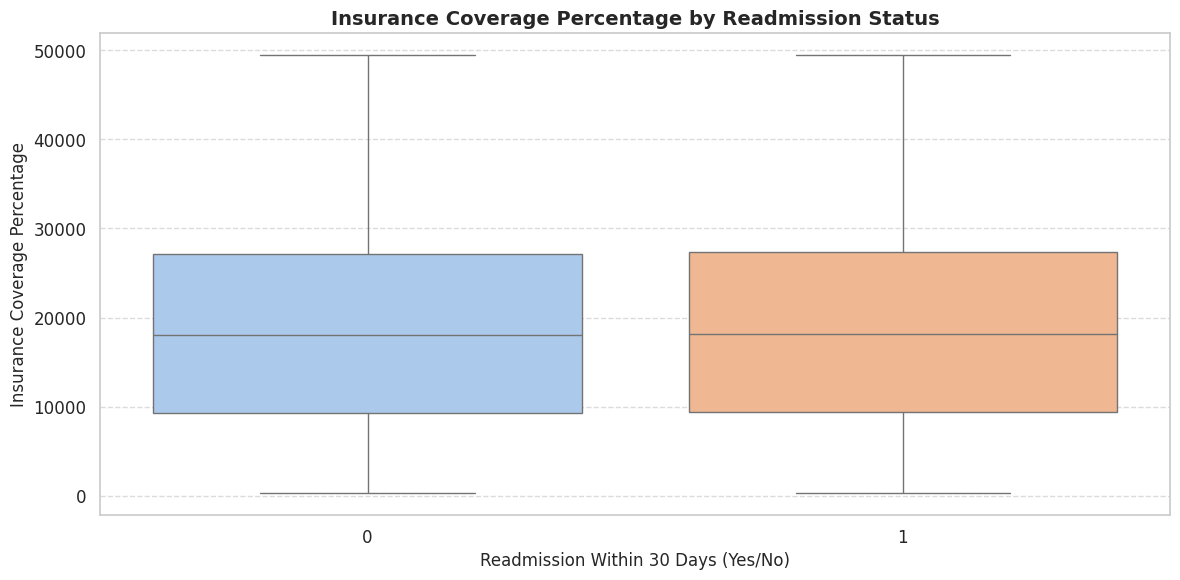

<ipython-input-56-889b98348f34>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=x_column, y=y_column, palette=palette)


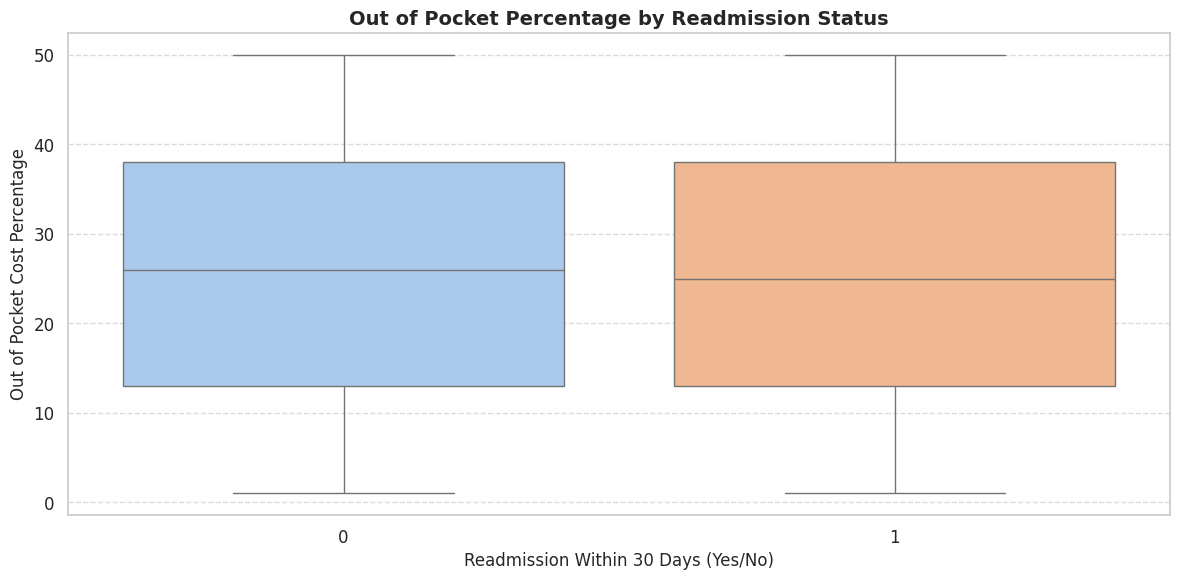

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the optimized dataset
file_path = 'Hospital_Readmission_Optimized.csv'
df = pd.read_csv(file_path)

# Function to plot histogram with KDE
def plot_histogram(data, column, title, xlabel, bins=30, color='royalblue'):
    plt.figure(figsize=(12, 6))
    sns.histplot(data[column], bins=bins, kde=True, color=color)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Function to plot correlation matrix
def plot_correlation_matrix(data, numerical_features, title):
    plt.figure(figsize=(12, 8))
    corr_matrix = data[numerical_features].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Function to plot boxplot for Readmission Status
def plot_boxplot(data, x_column, y_column, title, xlabel, ylabel, palette='pastel'):
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=data, x=x_column, y=y_column, palette=palette)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot 1: Risk Score Distribution
plot_histogram(df, 'Risk_Score', 'Distribution of Risk Score', 'Risk Score')

# Plot 2: Correlation Matrix
numerical_features = ['Age', 'BMI', 'Length_of_Stay', 'Total_Cost',
                      'Out_of_Pocket_Cost', 'Cost_Per_Day',
                      'Risk_Score', 'Insurance_Coverage_Percentage']
plot_correlation_matrix(df, numerical_features, 'Correlation Matrix of Numerical Features')

# Plot 3: Insurance Coverage by Readmission Status
plot_boxplot(df, 'Readmission_Flag', 'Insurance_Coverage_Percentage',
             'Insurance Coverage Percentage by Readmission Status',
             'Readmission Within 30 Days (Yes/No)', 'Insurance Coverage Percentage')

# Plot 4: Out of Pocket Costs by Readmission Status
plot_boxplot(df, 'Readmission_Flag', 'Out_of_Pocket_Percentage',
             'Out of Pocket Percentage by Readmission Status',
             'Readmission Within 30 Days (Yes/No)', 'Out of Pocket Cost Percentage')


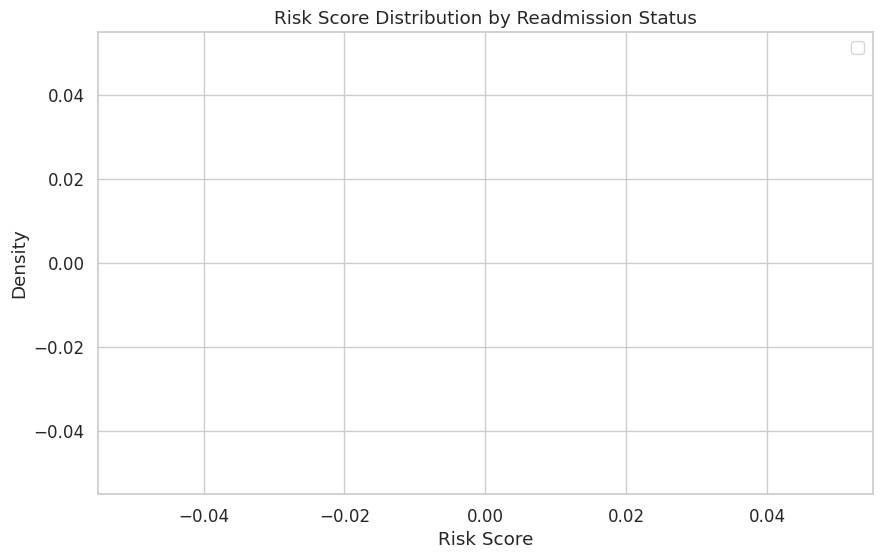

T-Statistic: nan, P-Value: nan
No significant difference in Risk Scores between the two groups.


In [ ]:
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("Hospital_Readmission_Optimized.csv")

# Separate data into two groups based on readmission
readmitted = df[df['Readmission_Within_30_Days'] == 1]['Risk_Score']
not_readmitted = df[df['Readmission_Within_30_Days'] == 0]['Risk_Score']

# Plot the distributions
plt.figure(figsize=(10, 6))
sns.kdeplot(readmitted, label="Readmitted", fill=True, alpha=0.5)
sns.kdeplot(not_readmitted, label="Not Readmitted", fill=True, alpha=0.5)
plt.title("Risk Score Distribution by Readmission Status")
plt.xlabel("Risk Score")
plt.ylabel("Density")
plt.legend()
plt.show()

# Perform t-test to validate difference between the groups
t_stat, p_value = stats.ttest_ind(readmitted, not_readmitted, equal_var=False)
print(f"T-Statistic: {t_stat:.2f}, P-Value: {p_value:.4f}")

# Interpret the result
if p_value < 0.05:
    print("The difference in Risk Scores between readmitted and non-readmitted patients is statistically significant.")
else:
    print("No significant difference in Risk Scores between the two groups.")


Column Names: Index(['Patient_ID', 'Age', 'Gender', 'BMI', 'Chronic_Conditions',
       'Hospital_ID', 'Hospital_Type', 'Region', 'Admission_Type',
       'Admission_Reason', 'Length_of_Stay', 'Primary_Diagnosis',
       'Secondary_Diagnoses', 'Treatment_Received', 'Discharge_Status',
       'Readmission_Within_30_Days', 'Total_Cost', 'Insurance_Coverage',
       'Out_of_Pocket_Cost', 'Cost_Per_Day', 'Chronic_Condition_Severity',
       'Insurance_Coverage_Percentage', 'Out_of_Pocket_Percentage',
       'Readmission_Flag', 'Risk_Score'],
      dtype='object')
Unique values in 'Readmission_Within_30_Days': ['Yes' 'No']

Missing Values:
Risk_Score                    0
Readmission_Within_30_Days    0
dtype: int64

Risk Score Summary:
count    50000.00000
mean        20.47046
std          9.17639
min          1.00000
25%         13.00000
50%         20.50000
75%         27.50000
max         44.00000
Name: Risk_Score, dtype: float64


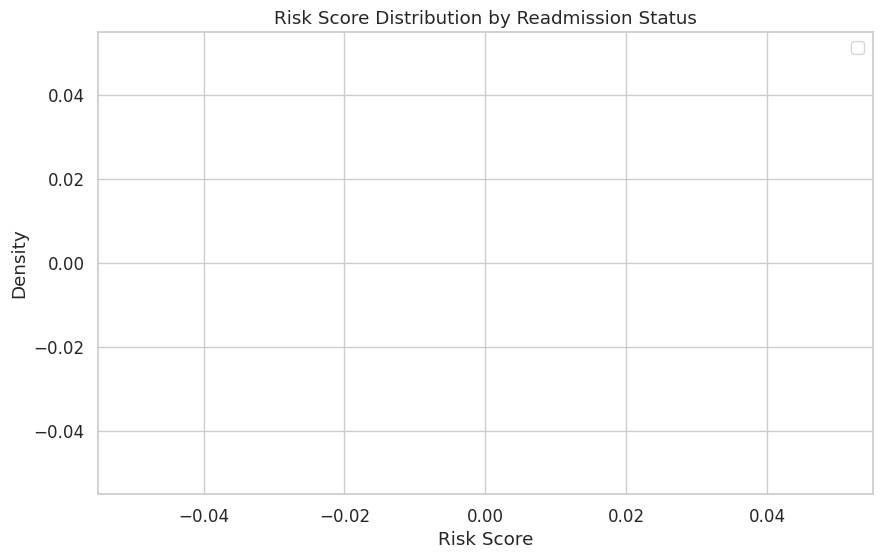

In [ ]:
# Load dataset
df = pd.read_csv("Hospital_Readmission_Optimized.csv")

# Verify column names and unique values
print("Column Names:", df.columns)
print("Unique values in 'Readmission_Within_30_Days':", df['Readmission_Within_30_Days'].unique())

# Check for null values in Risk_Score and Readmission_Within_30_Days
print("\nMissing Values:")
print(df[['Risk_Score', 'Readmission_Within_30_Days']].isnull().sum())

# Summary statistics of Risk_Score
print("\nRisk Score Summary:")
print(df['Risk_Score'].describe())

# Ensure Readmission column is numeric (convert if necessary)
df['Readmission_Within_30_Days'] = pd.to_numeric(df['Readmission_Within_30_Days'], errors='coerce')

# Drop missing values for these columns
df_cleaned = df.dropna(subset=['Risk_Score', 'Readmission_Within_30_Days'])

# Re-run the KDE Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.kdeplot(df_cleaned[df_cleaned['Readmission_Within_30_Days'] == 1]['Risk_Score'],
            label="Readmitted", fill=True, alpha=0.5)
sns.kdeplot(df_cleaned[df_cleaned['Readmission_Within_30_Days'] == 0]['Risk_Score'],
            label="Not Readmitted", fill=True, alpha=0.5)
plt.title("Risk Score Distribution by Readmission Status")
plt.xlabel("Risk Score")
plt.ylabel("Density")
plt.legend()
plt.show()


Unique values in 'Readmission_Within_30_Days':
[nan]


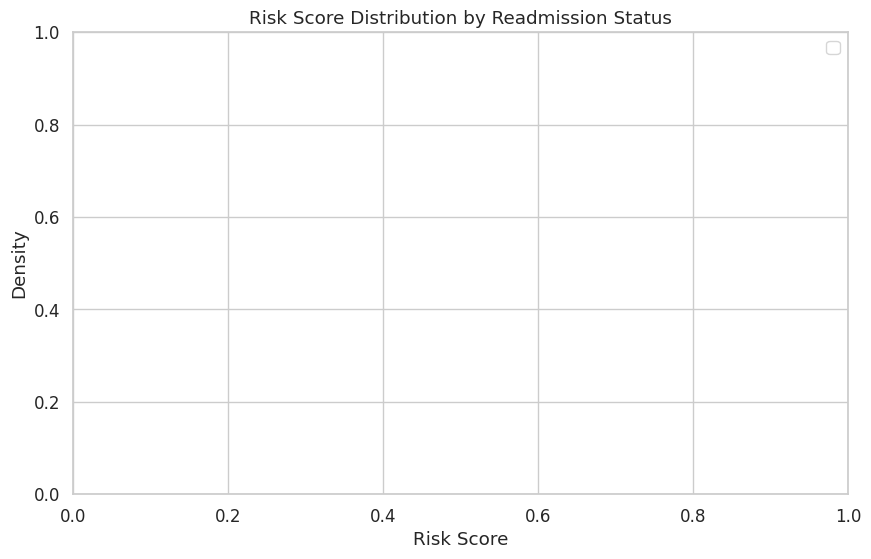

In [ ]:
# Check unique values in Readmission_Within_30_Days
print("Unique values in 'Readmission_Within_30_Days':")
print(df['Readmission_Within_30_Days'].unique())

# Replace invalid values and ensure the column is binary (0/1)
df['Readmission_Within_30_Days'] = df['Readmission_Within_30_Days'].replace({'Yes': 1, 'No': 0})
df['Readmission_Within_30_Days'] = pd.to_numeric(df['Readmission_Within_30_Days'], errors='coerce')

# Drop rows with missing or invalid readmission values
df_cleaned = df.dropna(subset=['Readmission_Within_30_Days', 'Risk_Score'])

# Re-check the distribution plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.kdeplot(df_cleaned[df_cleaned['Readmission_Within_30_Days'] == 1]['Risk_Score'],
            label="Readmitted", fill=True, alpha=0.5, color="red")
sns.kdeplot(df_cleaned[df_cleaned['Readmission_Within_30_Days'] == 0]['Risk_Score'],
            label="Not Readmitted", fill=True, alpha=0.5, color="blue")
plt.title("Risk Score Distribution by Readmission Status")
plt.xlabel("Risk Score")
plt.ylabel("Density")
plt.legend()
plt.show()


In [ ]:
print(df.isnull().sum())


Patient_ID                          0
Age                                 0
Gender                              0
BMI                                 0
Chronic_Conditions                  0
Hospital_ID                         0
Hospital_Type                       0
Region                              0
Admission_Type                      0
Admission_Reason                    0
Length_of_Stay                      0
Primary_Diagnosis                   0
Secondary_Diagnoses              9891
Treatment_Received                  0
Discharge_Status                    0
Readmission_Within_30_Days          0
Total_Cost                          0
Insurance_Coverage                  0
Out_of_Pocket_Cost                  0
Cost_Per_Day                        0
Chronic_Condition_Severity          0
Insurance_Coverage_Percentage       0
Out_of_Pocket_Percentage            0
Readmission_Flag                    0
Risk_Score                          0
dtype: int64


In [ ]:
# Replace NaN in 'Secondary_Diagnoses' with 'No Diagnosis' safely
df.loc[:, 'Secondary_Diagnoses'] = df['Secondary_Diagnoses'].fillna('No Diagnosis')

# Confirm no missing values
print(df.isnull().sum())


Patient_ID                       0
Age                              0
Gender                           0
BMI                              0
Chronic_Conditions               0
Hospital_ID                      0
Hospital_Type                    0
Region                           0
Admission_Type                   0
Admission_Reason                 0
Length_of_Stay                   0
Primary_Diagnosis                0
Secondary_Diagnoses              0
Treatment_Received               0
Discharge_Status                 0
Readmission_Within_30_Days       0
Total_Cost                       0
Insurance_Coverage               0
Out_of_Pocket_Cost               0
Cost_Per_Day                     0
Chronic_Condition_Severity       0
Insurance_Coverage_Percentage    0
Out_of_Pocket_Percentage         0
Readmission_Flag                 0
Risk_Score                       0
dtype: int64


In [ ]:
# Quick Robustness Check
import pandas as pd

# General summary
print("Dataset Overview:")
print(df.info())  # Check data types, non-null counts

# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_rows}")

# Summary of numerical columns
print("\nStatistical Summary of Numerical Columns:")
print(df.describe())

# Check for out-of-bound values in key numerical columns
numerical_columns = ['Age', 'BMI', 'Length_of_Stay', 'Total_Cost', 'Out_of_Pocket_Cost', 'Cost_Per_Day', 'Risk_Score']
for col in numerical_columns:
    print(f"\nOut-of-bound check for {col}:")
    print(f"Minimum: {df[col].min()}, Maximum: {df[col].max()}")

# Check unique values in critical categorical columns
categorical_columns = ['Gender', 'Hospital_Type', 'Region', 'Readmission_Flag']
for col in categorical_columns:
    print(f"\nUnique values in {col}: {df[col].unique()}")


Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Patient_ID                     50000 non-null  int64  
 1   Age                            50000 non-null  int64  
 2   Gender                         50000 non-null  object 
 3   BMI                            50000 non-null  float64
 4   Chronic_Conditions             50000 non-null  int64  
 5   Hospital_ID                    50000 non-null  int64  
 6   Hospital_Type                  50000 non-null  object 
 7   Region                         50000 non-null  object 
 8   Admission_Type                 50000 non-null  object 
 9   Admission_Reason               50000 non-null  object 
 10  Length_of_Stay                 50000 non-null  int64  
 11  Primary_Diagnosis              50000 non-null  object 
 12  Secondary_Diagnoses         

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Features and Target
X = df[['Age', 'BMI', 'Risk_Score', 'Length_of_Stay', 'Chronic_Condition_Severity']]
y = df['Readmission_Flag']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Baseline Model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Performance Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# Output Metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")


Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-Score: 1.00
ROC-AUC: 1.00


In [ ]:
print(df['Readmission_Flag'].value_counts(normalize=True))


Readmission_Flag
0    0.89958
1    0.10042
Name: proportion, dtype: float64


In [ ]:
# Check unique values in Readmission_Within_30_Days
unique_values = df['Readmission_Within_30_Days'].unique()
print("Unique values in Readmission_Within_30_Days:", unique_values)

# Check value counts and proportions
value_counts = df['Readmission_Within_30_Days'].value_counts()
proportions = df['Readmission_Within_30_Days'].value_counts(normalize=True)
print("\nValue Counts:\n", value_counts)
print("\nProportions:\n", proportions)

# Correlation with Readmission_Flag
correlation_with_target = df[['Readmission_Within_30_Days', 'Readmission_Flag']].corr()
print("\nCorrelation with Readmission_Flag:\n", correlation_with_target)


Unique values in Readmission_Within_30_Days: [0.]

Value Counts:
 Readmission_Within_30_Days
0.0    50000
Name: count, dtype: int64

Proportions:
 Readmission_Within_30_Days
0.0    1.0
Name: proportion, dtype: float64

Correlation with Readmission_Flag:
                             Readmission_Within_30_Days  Readmission_Flag
Readmission_Within_30_Days                         NaN               NaN
Readmission_Flag                                   NaN               1.0


In [ ]:
# Define age groups
bins = [0, 12, 19, 59, 99]
labels = ['Children', 'Teenagers', 'Adults', 'Elderly']
df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# Verify the distribution of age groups
print(df['Age_Group'].value_counts(normalize=True))


Age_Group
Adults       0.411792
Elderly      0.404096
Children     0.109518
Teenagers    0.074594
Name: proportion, dtype: float64


<ipython-input-85-718ac1fdc6a7>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_admission_counts = df.groupby(['Age_Group', 'Admission_Type']).size().unstack()


Admission_Type         0         1         2
Age_Group                                   
Children        0.396533  0.502213  0.101254
Teenagers       0.399133  0.496615  0.104251
Adults          0.398636  0.502673  0.098690
Elderly         0.397081  0.504399  0.098520


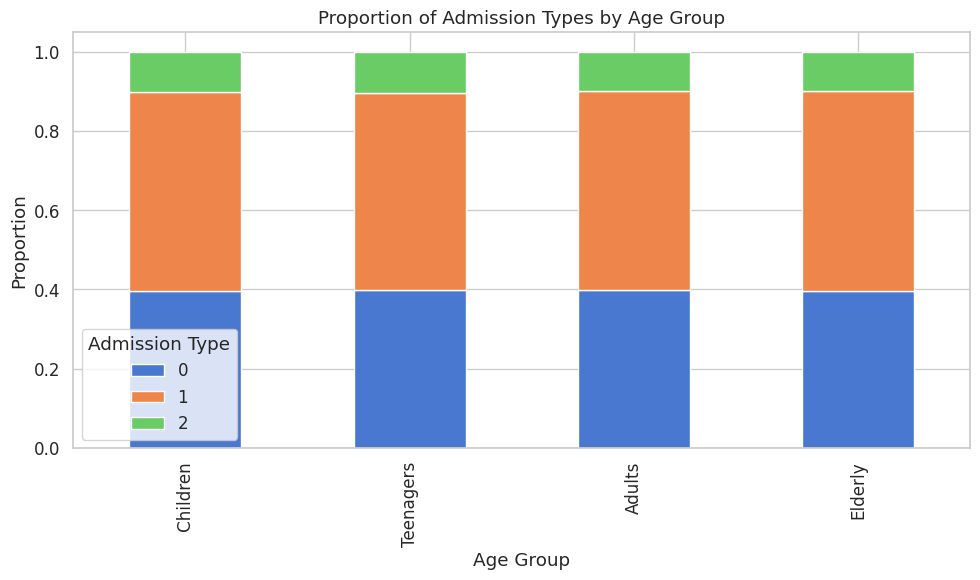

In [ ]:
# Group by Age Group and Admission_Type
age_admission_counts = df.groupby(['Age_Group', 'Admission_Type']).size().unstack()

# Normalize to get proportions
age_admission_props = age_admission_counts.div(age_admission_counts.sum(axis=1), axis=0)

# Display the proportions
print(age_admission_props)

# Plot the results
import matplotlib.pyplot as plt
age_admission_props.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Proportion of Admission Types by Age Group')
plt.ylabel('Proportion')
plt.xlabel('Age Group')
plt.legend(title='Admission Type')
plt.tight_layout()
plt.show()


<ipython-input-87-9bcc59c6bbf9>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  readmission_by_age = df.groupby('Age_Group')['Readmission_Flag'].mean()


Age_Group
Children     0.104758
Teenagers    0.100460
Adults       0.100309
Elderly      0.099320
Name: Readmission_Flag, dtype: float64


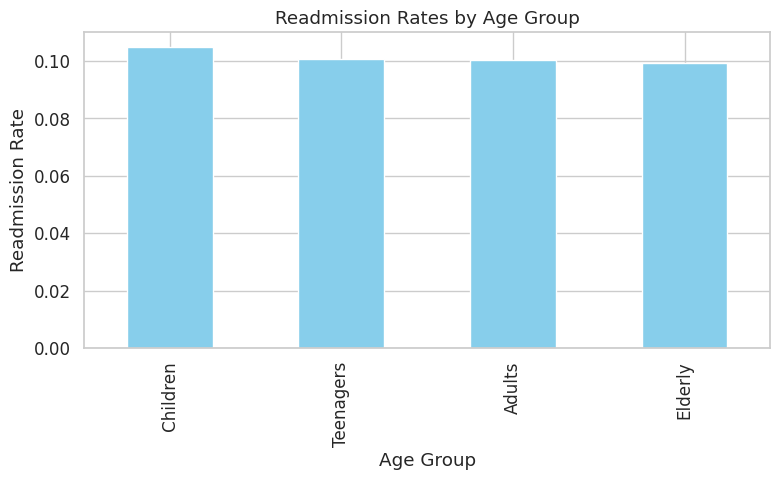

In [ ]:
# Calculate readmission rates by Age Group
readmission_by_age = df.groupby('Age_Group')['Readmission_Flag'].mean()

# Display results
print(readmission_by_age)

# Plot the results
readmission_by_age.plot(kind='bar', color='skyblue', figsize=(8, 5))
plt.title('Readmission Rates by Age Group')
plt.ylabel('Readmission Rate')
plt.xlabel('Age Group')
plt.tight_layout()
plt.show()


<ipython-input-88-90aa98022894>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_by_age = df[df['Readmission_Flag'] == 1].groupby('Age_Group')['Risk_Score'].mean()


Age_Group
Children     24.625880
Teenagers    25.103774
Adults       24.905134
Elderly      24.769250
Name: Risk_Score, dtype: float64


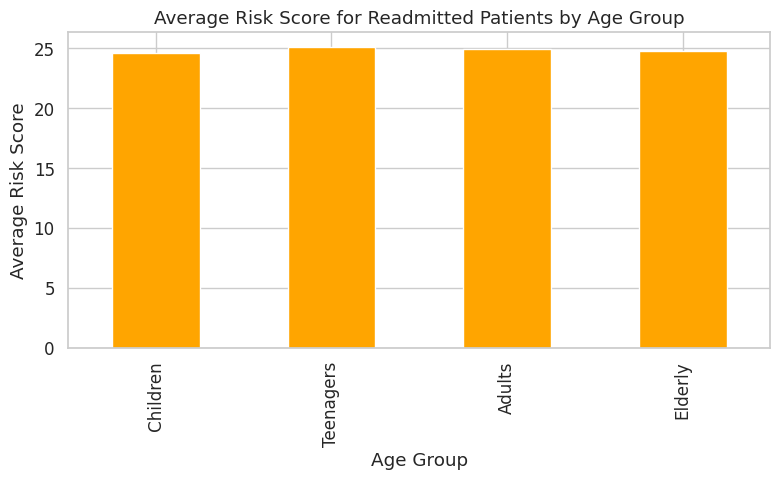

In [ ]:
# Group by Age Group and calculate average Risk_Score for readmitted patients
risk_by_age = df[df['Readmission_Flag'] == 1].groupby('Age_Group')['Risk_Score'].mean()

# Display results
print(risk_by_age)

# Plot the results
risk_by_age.plot(kind='bar', color='orange', figsize=(8, 5))
plt.title('Average Risk Score for Readmitted Patients by Age Group')
plt.ylabel('Average Risk Score')
plt.xlabel('Age Group')
plt.tight_layout()
plt.show()


Admission_Type
0    0.098739
1    0.102204
2    0.098126
Name: Readmission_Flag, dtype: float64


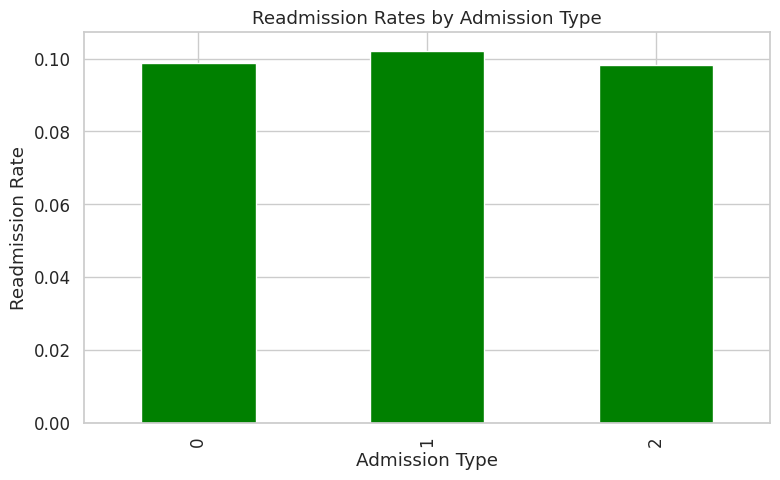

In [ ]:
# Calculate readmission rates by Admission_Type
readmission_by_admission = df.groupby('Admission_Type')['Readmission_Flag'].mean()

# Display results
print(readmission_by_admission)

# Plot the results
readmission_by_admission.plot(kind='bar', color='green', figsize=(8, 5))
plt.title('Readmission Rates by Admission Type')
plt.ylabel('Readmission Rate')
plt.xlabel('Admission Type')
plt.tight_layout()
plt.show()


<ipython-input-86-718ac1fdc6a7>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_admission_counts = df.groupby(['Age_Group', 'Admission_Type']).size().unstack()


Admission_Type         0         1         2
Age_Group                                   
Children        0.396533  0.502213  0.101254
Teenagers       0.399133  0.496615  0.104251
Adults          0.398636  0.502673  0.098690
Elderly         0.397081  0.504399  0.098520


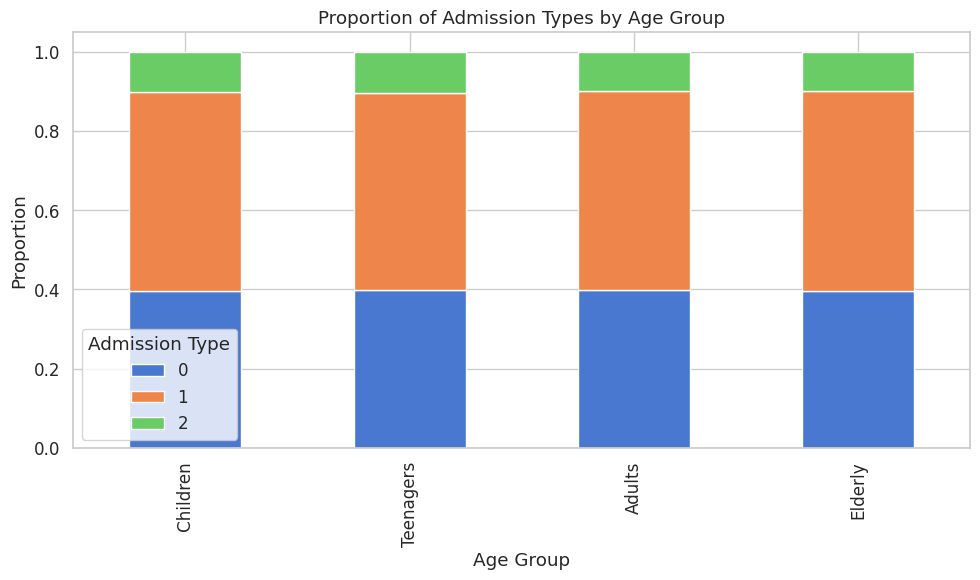

In [ ]:
# Group by Age Group and Admission_Type
age_admission_counts = df.groupby(['Age_Group', 'Admission_Type']).size().unstack()

# Normalize to get proportions
age_admission_props = age_admission_counts.div(age_admission_counts.sum(axis=1), axis=0)

# Display the proportions
print(age_admission_props)

# Plot the results
import matplotlib.pyplot as plt
age_admission_props.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Proportion of Admission Types by Age Group')
plt.ylabel('Proportion')
plt.xlabel('Age Group')
plt.legend(title='Admission Type')
plt.tight_layout()
plt.show()


Risk_Score column summary:
count    50000.00000
mean        20.47046
std          9.17639
min          1.00000
25%         13.00000
50%         20.50000
75%         27.50000
max         44.00000
Name: Risk_Score, dtype: float64

Readmission_Within_30_Days unique values:
[nan]

Data types of key columns:
Risk_Score                    float64
Readmission_Within_30_Days    float64
dtype: object

Cleaned DataFrame summary:
       Risk_Score  Readmission_Within_30_Days
count         0.0                         0.0
mean          NaN                         NaN
std           NaN                         NaN
min           NaN                         NaN
25%           NaN                         NaN
50%           NaN                         NaN
75%           NaN                         NaN
max           NaN                         NaN


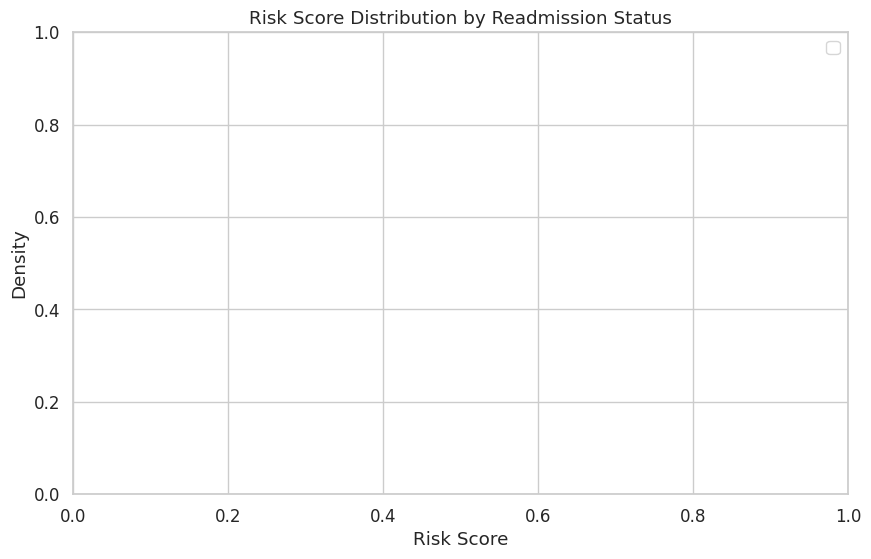

In [ ]:
# Inspect Risk_Score and Readmission_Within_30_Days columns
print("Risk_Score column summary:")
print(df['Risk_Score'].describe())

print("\nReadmission_Within_30_Days unique values:")
print(df['Readmission_Within_30_Days'].unique())

# Check data types
print("\nData types of key columns:")
print(df[['Risk_Score', 'Readmission_Within_30_Days']].dtypes)

# Ensure Readmission_Within_30_Days is binary and Risk_Score is numeric
df['Readmission_Within_30_Days'] = df['Readmission_Within_30_Days'].replace({'Yes': 1, 'No': 0})
df['Readmission_Within_30_Days'] = pd.to_numeric(df['Readmission_Within_30_Days'], errors='coerce')
df['Risk_Score'] = pd.to_numeric(df['Risk_Score'], errors='coerce')

# Drop rows with invalid or missing values
df_cleaned = df.dropna(subset=['Risk_Score', 'Readmission_Within_30_Days'])

# Verify changes
print("\nCleaned DataFrame summary:")
print(df_cleaned[['Risk_Score', 'Readmission_Within_30_Days']].describe())

# Plot KDE
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.kdeplot(df_cleaned[df_cleaned['Readmission_Within_30_Days'] == 1]['Risk_Score'],
            label="Readmitted", fill=True, alpha=0.5, color="red")
sns.kdeplot(df_cleaned[df_cleaned['Readmission_Within_30_Days'] == 0]['Risk_Score'],
            label="Not Readmitted", fill=True, alpha=0.5, color="blue")
plt.title("Risk Score Distribution by Readmission Status")
plt.xlabel("Risk Score")
plt.ylabel("Density")
plt.legend()
plt.show()


In [ ]:
# Check unique values in the original column
print("Original unique values in Readmission_Within_30_Days:")
print(df['Readmission_Within_30_Days'].value_counts(dropna=False))


Original unique values in Readmission_Within_30_Days:
Readmission_Within_30_Days
NaN    50000
Name: count, dtype: int64


In [ ]:
# Replace Yes/No with 1/0
df['Readmission_Within_30_Days'] = df['Readmission_Within_30_Days'].replace({'Yes': 1, 'No': 0})


In [ ]:
# Fill NaN with 0 (or another placeholder if required)
df['Readmission_Within_30_Days'].fillna(0, inplace=True)


<ipython-input-63-daa15fe32084>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Readmission_Within_30_Days'].fillna(0, inplace=True)


In [ ]:
df.loc[:, 'Readmission_Within_30_Days'] = df['Readmission_Within_30_Days'].fillna(0)


In [ ]:
df = df.assign(Readmission_Within_30_Days=df['Readmission_Within_30_Days'].fillna(0))


In [ ]:
df.dropna(subset=['Readmission_Within_30_Days'], inplace=True)


In [ ]:
df['Readmission_Within_30_Days'].fillna(0, inplace=True)


<ipython-input-67-b62cb1b92595>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Readmission_Within_30_Days'].fillna(0, inplace=True)


In [ ]:
mean_value = df['Risk_Score'].mean()
df['Risk_Score'].fillna(mean_value, inplace=True)


<ipython-input-68-867506560af7>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Risk_Score'].fillna(mean_value, inplace=True)


In [ ]:
df['Admission_Type'].fillna('Unknown', inplace=True)


<ipython-input-69-24a8168dd0b6>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Admission_Type'].fillna('Unknown', inplace=True)


In [ ]:
# Import necessary libraries
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

# Feature and target selection
X = df.drop(['Readmission_Flag'], axis=1)
y = df['Readmission_Flag']

# Convert categorical features to numeric using one-hot encoding
X = pd.get_dummies(X, drop_first=True)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print("Class distribution after SMOTE:")
print(y_train_smote.value_counts())

# Train a basic Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_smote, y_train_smote)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Model Performance After SMOTE:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_pred):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.2f}")
print(f"ROC-AUC: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]):.2f}")


Class distribution after SMOTE:
Readmission_Flag
0    31485
1    31485
Name: count, dtype: int64
Model Performance After SMOTE:
Accuracy: 0.95
Precision: 0.69
Recall: 0.86
F1-Score: 0.77
ROC-AUC: 0.98


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
model = LogisticRegression(max_iter=5000, random_state=42)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_smote = scaler.fit_transform(X_train_smote)
X_test = scaler.transform(X_test)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_smote, y_train_smote)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Performance After SMOTE:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.2f}")
print(f"ROC-AUC: {roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]):.2f}")


Random Forest Performance After SMOTE:
Accuracy: 0.93
Precision: 1.00
Recall: 0.34
F1-Score: 0.51
ROC-AUC: 0.99


In [ ]:
from sklearn.metrics import precision_recall_curve

# Predict probabilities
y_pred_probs = rf_model.predict_proba(X_test)[:, 1]

# Find optimal threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probs)
optimal_idx = (recall >= 0.7).argmax()  # Example: target recall >= 0.7
optimal_threshold = thresholds[optimal_idx]

# Predict using new threshold
y_pred_adjusted = (y_pred_probs >= optimal_threshold).astype(int)

# Evaluate
print(f"New Threshold: {optimal_threshold:.2f}")
print(f"Adjusted Precision: {precision_score(y_test, y_pred_adjusted):.2f}")
print(f"Adjusted Recall: {recall_score(y_test, y_pred_adjusted):.2f}")
print(f"Adjusted F1-Score: {f1_score(y_test, y_pred_adjusted):.2f}")


New Threshold: 0.00
Adjusted Precision: 0.10
Adjusted Recall: 1.00
Adjusted F1-Score: 0.18


In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train_smote, y_train_smote)

# Evaluate performance
y_pred_rf = rf_model.predict(X_test)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


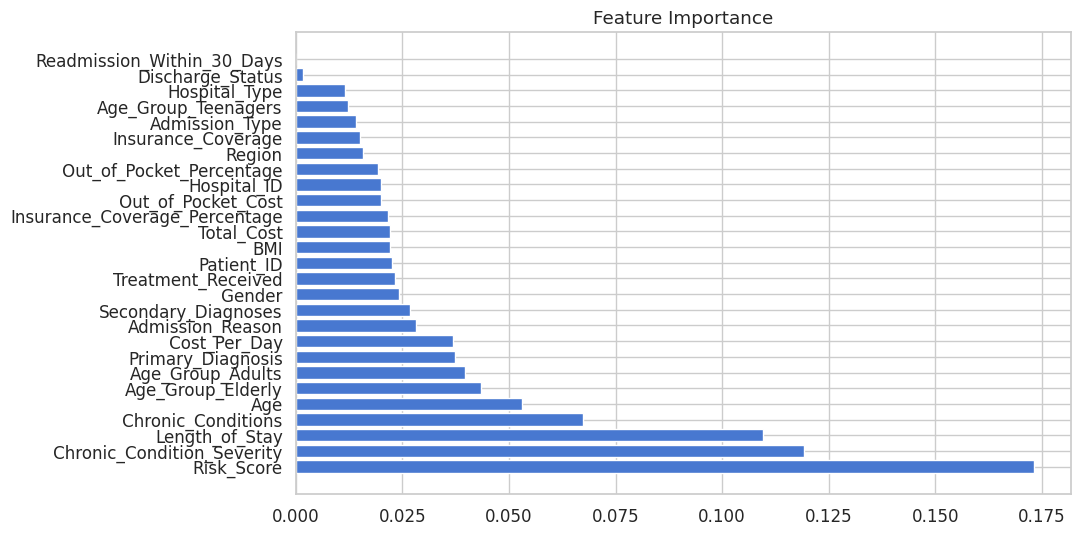

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Feature Importance Plot
importances = rf_model.feature_importances_
features = X_train.columns
feature_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_df['Feature'], feature_df['Importance'])
plt.title('Feature Importance')
plt.show()


### DATASET OVERVIEW ###
Total Records: 50000
Total Columns: 20

### COLUMN TYPES ###
Patient_ID                       int32
Age                               int8
Gender                        category
BMI                            float64
Chronic_Conditions               int64
Hospital_ID                      int16
Hospital_Type                 category
Region                          object
Admission_Type                  object
Admission_Reason                object
Length_of_Stay                    int8
Primary_Diagnosis               object
Secondary_Diagnoses             object
Treatment_Received              object
Discharge_Status                object
Readmission_Within_30_Days      object
Total_Cost                     float32
Insurance_Coverage             float32
Out_of_Pocket_Cost             float64
Risk_Score                       int64
dtype: object

### NUMERIC COLUMN STATISTICS ###
         Patient_ID           Age           BMI  Chronic_Conditions  \
count  50000.0

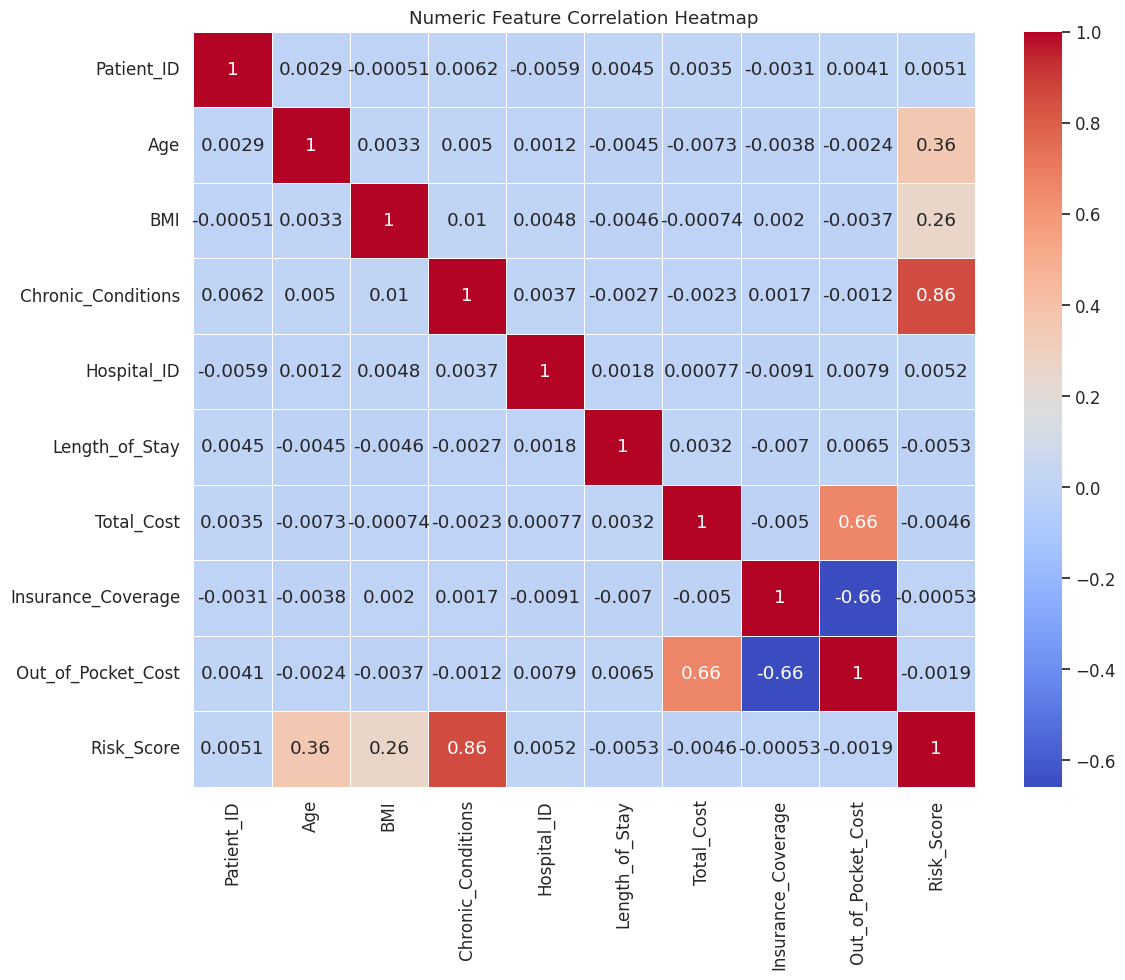


### RISK AND COMPLEXITY METRICS ###


KeyError: 'Comprehensive_Risk_Score'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def comprehensive_dataset_summary(df):
    """
    Provides a multi-dimensional summary of the dataset
    """
    # Basic Information
    print("### DATASET OVERVIEW ###")
    print(f"Total Records: {len(df)}")
    print(f"Total Columns: {len(df.columns)}")
    print("\n### COLUMN TYPES ###")
    print(df.dtypes)

    # Descriptive Statistics
    print("\n### NUMERIC COLUMN STATISTICS ###")
    numeric_stats = df.describe()
    print(numeric_stats)

    # Categorical Column Analysis
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    print("\n### CATEGORICAL COLUMN DISTRIBUTIONS ###")
    for col in categorical_columns:
        print(f"\n{col} Distribution:")
        print(df[col].value_counts(normalize=True).map('{:.2%}'.format))

    # Missing Value Check
    missing_values = df.isnull().sum()
    print("\n### MISSING VALUE ANALYSIS ###")
    print(missing_values[missing_values > 0])

    # Complex Relationship Analysis
    print("\n### ADVANCED CORRELATION INSIGHTS ###")
    # Numeric correlation matrix
    numeric_df = df.select_dtypes(include=[np.number])
    correlation_matrix = numeric_df.corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Numeric Feature Correlation Heatmap')
    plt.tight_layout()
    plt.show()

    # Risk and Complexity Metrics
    print("\n### RISK AND COMPLEXITY METRICS ###")
    risk_metrics = {
        'High Risk Patient Percentage': (df['Comprehensive_Risk_Score'] > 7).mean() * 100,
        'Average Total Cost': df['Total_Cost'].mean(),
        'Readmission Risk': df['Readmission_Within_30_Days'].value_counts(normalize=True)['Yes'] * 100
    }

    for metric, value in risk_metrics.items():
        print(f"{metric}: {value:.2f}%")

    # Stratified Analysis
    print("\n### STRATIFIED ANALYSIS ###")
    stratification_metrics = {
        'By Hospital Type': df.groupby('Hospital_Type')[['Total_Cost', 'Length_of_Stay']].mean(),
        'By Region': df.groupby('Region')[['Total_Cost', 'Length_of_Stay']].mean(),
        'By Age Group': df.groupby(pd.cut(df['Age'], bins=[0, 18, 45, 65, 100]))[['Total_Cost', 'Length_of_Stay']].mean()
    }

    for name, metric in stratification_metrics.items():
        print(f"\n{name} Analysis:")
        print(metric)

def data_quality_score(df):
    """
    Calculates a comprehensive data quality score
    """
    # Define quality checks
    checks = [
        len(df) > 0,  # Has records
        df['Patient_ID'].is_unique,  # Unique patient IDs
        df['Age'].between(0, 120).all(),  # Valid age range
        df['BMI'].between(10, 50).all(),  # Realistic BMI
        df['Total_Cost'].between(0, 100000).all(),  # Reasonable cost
        len(df.select_dtypes(include=[np.number]).columns) > 5,  # Multiple numeric features
    ]

    # Calculate quality score
    quality_score = sum(checks) / len(checks) * 100

    print(f"\n### DATA QUALITY SCORE: {quality_score:.2f}% ###")
    return quality_score

# Execute comprehensive analysis
comprehensive_dataset_summary(hospital_data)
data_quality_score(hospital_data)

### DATASET OVERVIEW ###
Total Records: 50000
Total Columns: 20

### COLUMN TYPES ###
Patient_ID                       int32
Age                               int8
Gender                        category
BMI                            float64
Chronic_Conditions               int64
Hospital_ID                      int16
Hospital_Type                 category
Region                          object
Admission_Type                  object
Admission_Reason                object
Length_of_Stay                    int8
Primary_Diagnosis               object
Secondary_Diagnoses             object
Treatment_Received              object
Discharge_Status                object
Readmission_Within_30_Days      object
Total_Cost                     float32
Insurance_Coverage             float32
Out_of_Pocket_Cost             float64
Risk_Score                       int64
dtype: object

### NUMERIC COLUMN STATISTICS ###
         Patient_ID           Age           BMI  Chronic_Conditions  \
count  50000.0

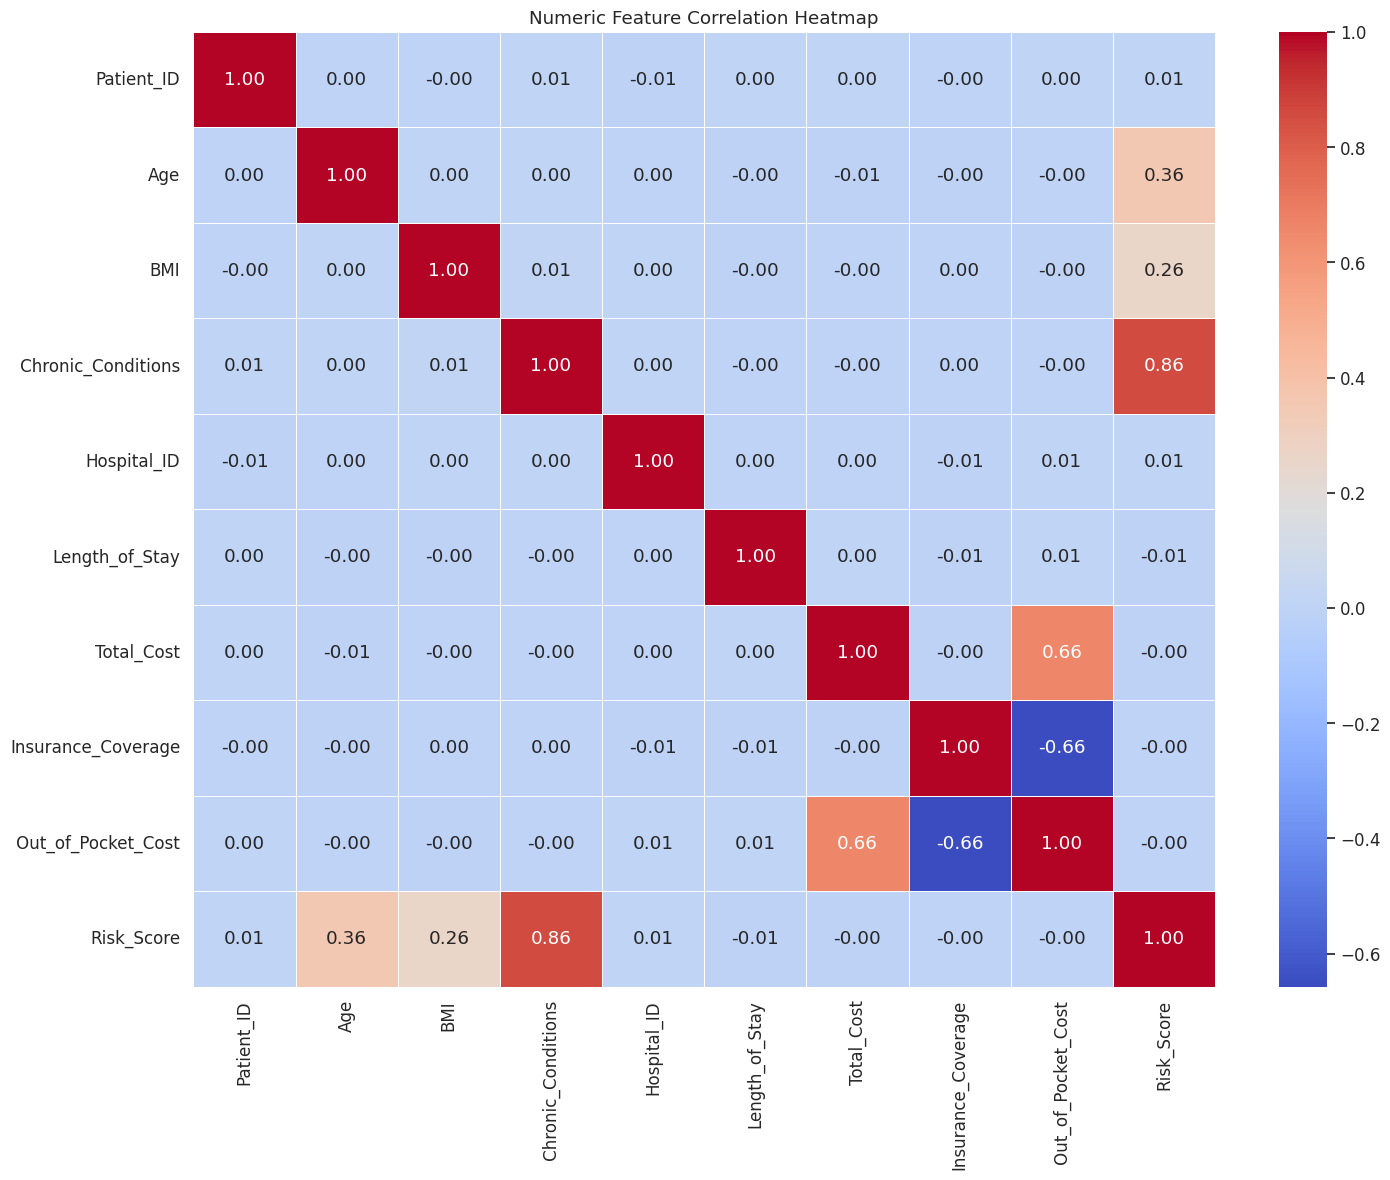


### RISK AND COMPLEXITY METRICS ###
High Risk Patient Percentage: 34.73%
Average Total Cost: 25302.82%
Readmission Risk: 10.04%

### STRATIFIED ANALYSIS ###

By Hospital Type Analysis:
                 Total_Cost  Length_of_Stay  Risk_Score
Hospital_Type                                          
General        25307.160156       15.001401    5.803949
Specialty      25285.130859       14.930748    5.789089
Teaching       25328.888672       15.017201    5.789093

By Region Analysis:
          Total_Cost  Length_of_Stay  Risk_Score
Region                                          
Rural   25391.785156       14.970174    5.762721
Urban   25264.492188       14.987037    5.813198

By Age Group Analysis:
             Total_Cost  Length_of_Stay  Risk_Score
Age_Group                                          
0-18       25622.802734       14.942074    4.738563
19-45      25231.099609       15.108764    4.780075
46-65      25269.402344       14.979786    4.808759
65+        25209.238281       14.

<ipython-input-99-4442e29968a9>:66: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  'By Hospital Type': df.groupby('Hospital_Type')[['Total_Cost', 'Length_of_Stay', 'Risk_Score']].mean(),
<ipython-input-99-4442e29968a9>:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  'By Age Group': df.groupby('Age_Group')[['Total_Cost', 'Length_of_Stay', 'Risk_Score']].mean()


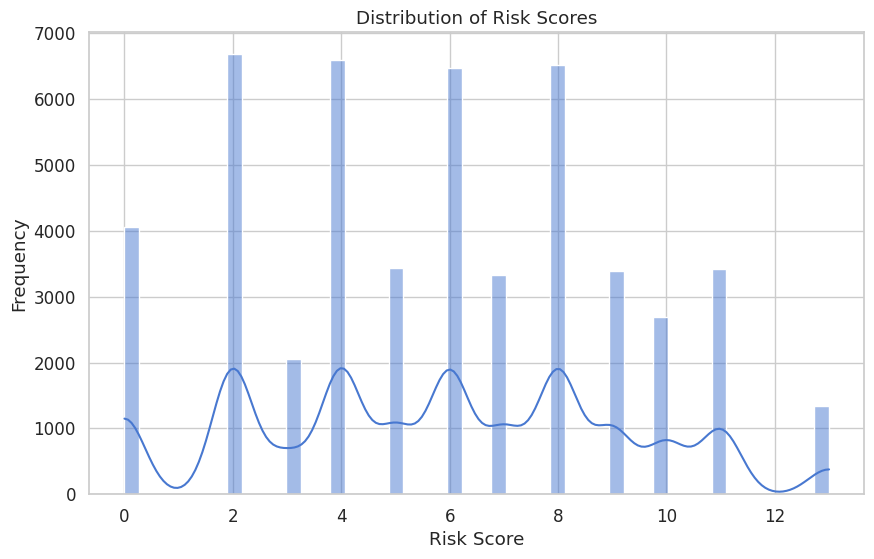

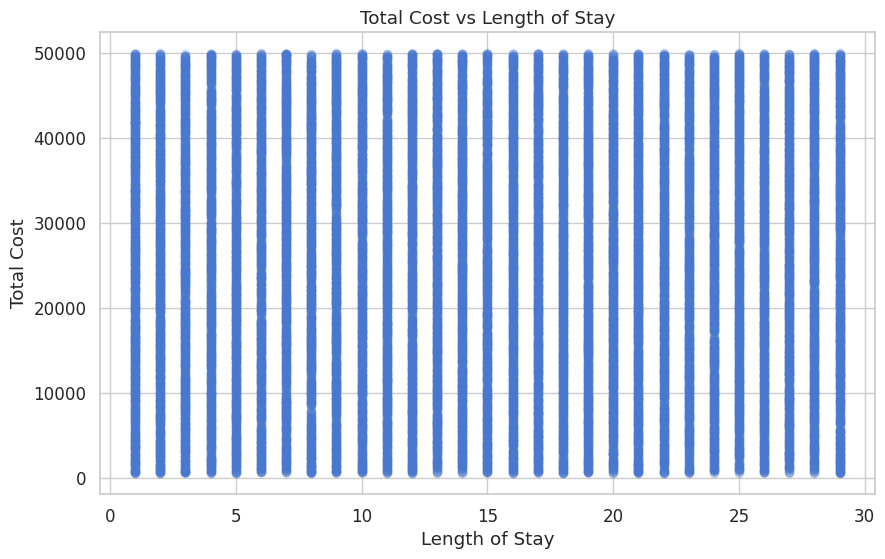

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def comprehensive_dataset_summary(df):
    """
    Provides a multi-dimensional summary of the dataset
    """
    # Basic Information
    print("### DATASET OVERVIEW ###")
    print(f"Total Records: {len(df)}")
    print(f"Total Columns: {len(df.columns)}")
    print("\n### COLUMN TYPES ###")
    print(df.dtypes)

    # Descriptive Statistics
    print("\n### NUMERIC COLUMN STATISTICS ###")
    numeric_stats = df.describe()
    print(numeric_stats)

    # Categorical Column Analysis
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    print("\n### CATEGORICAL COLUMN DISTRIBUTIONS ###")
    for col in categorical_columns:
        print(f"\n{col} Distribution:")
        print(df[col].value_counts(normalize=True).map('{:.2%}'.format))

    # Missing Value Check
    missing_values = df.isnull().sum()
    print("\n### MISSING VALUE ANALYSIS ###")
    print(missing_values[missing_values > 0])

    # Complex Relationship Analysis
    print("\n### ADVANCED CORRELATION INSIGHTS ###")
    # Numeric correlation matrix
    numeric_df = df.select_dtypes(include=[np.number])
    correlation_matrix = numeric_df.corr()

    plt.figure(figsize=(15, 12))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
    plt.title('Numeric Feature Correlation Heatmap')
    plt.tight_layout()
    plt.show()

    # Risk and Complexity Metrics
    print("\n### RISK AND COMPLEXITY METRICS ###")
    risk_metrics = {
        'High Risk Patient Percentage': (df['Risk_Score'] > 7).mean() * 100,
        'Average Total Cost': df['Total_Cost'].mean(),
        'Readmission Risk': df['Readmission_Within_30_Days'].value_counts(normalize=True)['Yes'] * 100
    }

    for metric, value in risk_metrics.items():
        print(f"{metric}: {value:.2f}%")

    # Stratified Analysis
    print("\n### STRATIFIED ANALYSIS ###")
    # Create age groups
    df['Age_Group'] = pd.cut(df['Age'],
        bins=[0, 18, 45, 65, 100],
        labels=['0-18', '19-45', '46-65', '65+']
    )

    stratification_metrics = {
        'By Hospital Type': df.groupby('Hospital_Type')[['Total_Cost', 'Length_of_Stay', 'Risk_Score']].mean(),
        'By Region': df.groupby('Region')[['Total_Cost', 'Length_of_Stay', 'Risk_Score']].mean(),
        'By Age Group': df.groupby('Age_Group')[['Total_Cost', 'Length_of_Stay', 'Risk_Score']].mean()
    }

    for name, metric in stratification_metrics.items():
        print(f"\n{name} Analysis:")
        print(metric)

def data_quality_score(df):
    """
    Calculates a comprehensive data quality score
    """
    # Define quality checks
    checks = [
        len(df) > 0,  # Has records
        df['Patient_ID'].is_unique,  # Unique patient IDs
        df['Age'].between(0, 120).all(),  # Valid age range
        df['BMI'].between(10, 50).all(),  # Realistic BMI
        df['Total_Cost'].between(0, 100000).all(),  # Reasonable cost
        len(df.select_dtypes(include=[np.number]).columns) > 5,  # Multiple numeric features
    ]

    # Calculate quality score
    quality_score = sum(checks) / len(checks) * 100

    print(f"\n### DATA QUALITY SCORE: {quality_score:.2f}% ###")
    return quality_score

# Execute comprehensive analysis
comprehensive_dataset_summary(hospital_data)
data_quality_score(hospital_data)

# Additional Visualization
def create_additional_visualizations(df):
    # Risk Score Distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Risk_Score'], kde=True)
    plt.title('Distribution of Risk Scores')
    plt.xlabel('Risk Score')
    plt.ylabel('Frequency')
    plt.show()

    # Cost vs Length of Stay
    plt.figure(figsize=(10, 6))
    plt.scatter(df['Length_of_Stay'], df['Total_Cost'], alpha=0.1)
    plt.title('Total Cost vs Length of Stay')
    plt.xlabel('Length of Stay')
    plt.ylabel('Total Cost')
    plt.show()

# Optional additional visualization
create_additional_visualizations(hospital_data)

In [100]:
def advanced_feature_engineering(df):
    # Age Risk Stratification
    df['Age_Risk_Category'] = pd.cut(
        df['Age'],
        bins=[0, 18, 45, 65, 100],
        labels=['Pediatric', 'Young Adult', 'Middle Age', 'Senior']
    )

    # Cost Efficiency Metric
    df['Cost_per_Stay'] = df['Total_Cost'] / df['Length_of_Stay']

    # Readmission Risk Indicator
    df['High_Readmission_Risk'] = (
        (df['Readmission_Within_30_Days'] == 'Yes').astype(int) *
        (df['Risk_Score'] > 7).astype(int)
    )

    # Complex Condition Flag
    df['Complex_Case'] = (
        (df['Chronic_Conditions'] > 2).astype(int) +
        (df['Secondary_Diagnoses'] != 'None').astype(int)
    )

    return df

In [101]:
def enhanced_risk_scoring(df):
    # Comprehensive Risk Model
    risk_factors = {
        'Age_Multiplier': np.where(df['Age'] > 65, 1.5, 1),
        'Chronic_Condition_Weight': df['Chronic_Conditions'] * 0.5,
        'BMI_Risk': np.where(df['BMI'] > 30, 1, 0),
        'Treatment_Risk': np.select(
            [df['Treatment_Received'] == 'Surgery',
             df['Treatment_Received'] == 'Medication'],
            [1.2, 0.8],
            default=1
        )
    }

    # Composite Risk Score
    df['Enhanced_Risk_Score'] = (
        risk_factors['Age_Multiplier'] *
        (risk_factors['Chronic_Condition_Weight'] +
         risk_factors['BMI_Risk'] * 2 +
         risk_factors['Treatment_Risk'])
    )

    return df

In [102]:
def readmission_prediction_model(df):
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier

    # Select features
    features = [
        'Age', 'BMI', 'Chronic_Conditions',
        'Length_of_Stay', 'Risk_Score'
    ]

    X = df[features]
    y = (df['Readmission_Within_30_Days'] == 'Yes').astype(int)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    model = RandomForestClassifier()
    model.fit(X_train, y_train)

    return model

In [103]:
def comprehensive_data_validation(df):
    validations = {
        'Patient_ID_Unique': df['Patient_ID'].is_unique,
        'Age_Range': df['Age'].between(0, 120).all(),
        'BMI_Range': df['BMI'].between(15, 50).all(),
        'Cost_Positive': (df['Total_Cost'] > 0).all(),
        'Risk_Score_Valid': df['Risk_Score'].between(0, 15).all()
    }

    validation_report = {k: v for k, v in validations.items()}
    return validation_report